# **Colombia**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from scipy import stats

## *Calidad de los Datos*

>Importar datos

In [2]:
df = pd.read_csv(r"col_pros.csv", encoding='latin_1', low_memory=False)
df.info()

FileNotFoundError: [Errno 2] No such file or directory: 'col_pros.csv'

> Convertir fechas a datetime

In [3]:
# Lista de columnas que quieres convertir
columnas_fecha = ["fecha_consulta", "fecha_inicio_sintomas", "fecha_notificacion", "fecha_nacimiento", "fecha_hospitalizacion"]

for col in columnas_fecha:
    df[col] = pd.to_datetime(df[col], format='mixed')
    print(f"Columna '{col}' convertida a datetime.")

Columna 'fecha_consulta' convertida a datetime.
Columna 'fecha_inicio_sintomas' convertida a datetime.
Columna 'fecha_notificacion' convertida a datetime.
Columna 'fecha_nacimiento' convertida a datetime.
Columna 'fecha_hospitalizacion' convertida a datetime.


> Valores Faltantes

In [5]:
faltantes = df.isnull().sum()
print("\n   Valores faltantes por variable:")
faltantes[faltantes > 0]


   Valores faltantes por variable:


fecha_consulta               93
fecha_hospitalizacion    546996
fecha_inicio_sintomas        53
fecha_nacimiento          30097
dtype: int64

## *Descriptivo de Variables*

In [4]:
def describir_categorica(columna, col_evento="evento"):
    # Conteos y proporciones generales
    tabla = pd.DataFrame({
        "Conteo": columna.value_counts(dropna=False),
        "Proporción": columna.value_counts(normalize=True, dropna=False).round(4)
    })

    # Renombrar índice si hay NaN
    tabla.index = tabla.index.map(lambda x: "NaN" if pd.isna(x) else x)

    # Conteos de la variable evento cruzada con la categórica
    crosstab_evento = pd.crosstab(df[columna.name], df[col_evento])

    # Unir todo
    tabla_completa = tabla.join(crosstab_evento)

    # Agregar proporciones específicas para 'Clasico' y 'Grave' si existen
    if "Clasico" in crosstab_evento.columns:
        tabla_completa["Prop_Clasico"] = (tabla_completa["Clasico"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Clasico"] = 0

    if "Grave" in crosstab_evento.columns:
        tabla_completa["Prop_Grave"] = (tabla_completa["Grave"] / tabla_completa["Conteo"]).round(4)
    else:
        tabla_completa["Prop_Grave"] = 0

    print(f"\n📌 Variable: {columna.name}")
    print(tabla_completa)
    print("\n-----------------------------------")



### *Variables Demográficas*

- Ciclo vital
- Sexo
- Pertenencia étnica
- Regimen de salud

In [8]:
print("DESCRIPCIÓN DE VARIABLES CATEGÓRICAS")
describir_categorica(df["ciclo_vital"])
describir_categorica(df["sexo"])
describir_categorica(df["grupo_etnico"])
describir_categorica(df["regimen_salud"])

DESCRIPCIÓN DE VARIABLES CATEGÓRICAS

📌 Variable: ciclo_vital
                  Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
ciclo_vital                                                                   
Adulto            354532      0.3741   350418   4114        0.9884      0.0116
Adolescencia      268131      0.2829   263632   4499        0.9832      0.0168
Infancia          154055      0.1625   150961   3094        0.9799      0.0201
Primera infancia  101855      0.1075   100016   1839        0.9819      0.0181
Adulto mayor       55679      0.0587    54696    983        0.9823      0.0177
Menor de 1 año      9056      0.0096     8679    377        0.9584      0.0416
Ancianidad          4497      0.0047     4391    106        0.9764      0.0236
Desconocido            5      0.0000        5      0        1.0000      0.0000

-----------------------------------

📌 Variable: sexo
           Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
sexo                 

El análisis de las variables categóricas muestra que la mayor proporción de casos de dengue se concentra en la población adulta (37,4%), seguida por la adolescencia (28,3%) e infancia (16,3%), mientras que los menores de un año y las personas en ancianidad representan proporciones muy bajas (menos del 1% y 0,5% respectivamente). En todos los grupos etarios predomina el dengue clásico, con proporciones superiores al 97%, aunque se observa una mayor vulnerabilidad relativa a la forma grave en los menores de un año (4,2%). Respecto al sexo, los casos se distribuyen de manera relativamente equilibrada, con ligera predominancia en hombres (52,4%), sin diferencias notables en la proporción de dengue grave entre hombres y mujeres (alrededor del 1,6%). En cuanto al grupo étnico, la gran mayoría de los casos se reportan en la categoría “Otro” (94,9%), lo cual podría reflejar limitaciones en la clasificación o registro, mientras que afrocolombianos, indígenas y población Rom tienen menor representación (<5%), aunque en estos últimos dos grupos la proporción de dengue grave es ligeramente mayor (2,1% y 2,2% respectivamente). Finalmente, al analizar el régimen de salud, se observa que los afiliados al régimen subsidiado (46,2%) y contributivo (44,4%) concentran la mayoría de los casos, con una proporción de dengue grave más alta en el subsidiado (1,8%) y en los no asegurados (2,1%), lo que sugiere posibles desigualdades en el acceso a la atención oportuna. 

> Edad

In [28]:
# Subconjunto de datos para análisis de edad (excluye "Menor de 1 año")
df_edad = df[df["ciclo_vital"] != "Menor de 1 año"].copy()

# Definir orden cronológico SIN "Menor de 1 año"
orden_ciclos_edad = [
    "Primera infancia",
    "Infancia",
    "Adolescencia",
    "Adulto",
    "Adulto mayor",
    "Ancianidad"
]

df_edad["ciclo_vital"] = pd.Categorical(
    df_edad["ciclo_vital"], 
    categories=orden_ciclos_edad, 
    ordered=True
)

In [29]:
def tabla_descriptiva(df, variable, grupo=None):
    """
    Genera una tabla descriptiva (media, mediana, DE, IQR, etc.)
    por grupos (ej. ciclo vital).
    """
    if grupo:
        desc = df.groupby(grupo)[variable].agg(
            n = 'count',
            media = 'mean',
            mediana = 'median',
            sd = 'std',
            q25 = lambda x: np.percentile(x, 25),
            q75 = lambda x: np.percentile(x, 75),
            minimo = 'min',
            maximo = 'max'
        ).reset_index()
    else:
        desc = df[variable].agg(
            n = 'count',
            media = 'mean',
            mediana = 'median',
            sd = 'std',
            q25 = lambda x: np.percentile(x, 25),
            q75 = lambda x: np.percentile(x, 75),
            minimo = 'min',
            maximo = 'max'
        ).to_frame().T
    return desc.round(2)

tabla = tabla_descriptiva(df_edad, variable="edad_años", grupo="ciclo_vital")
tabla

C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_15540\2790285505.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df.groupby(grupo)[variable].agg(


ciclo_vital       n  media  mediana     sd   q25   q75  minimo  maximo
0  Primera infancia  101855   2.37      2.0   1.19   1.0   3.0       1       4
1          Infancia  154055   7.08      7.0   1.40   6.0   8.0       5       9
2      Adolescencia  268131  13.99     14.0   2.77  12.0  16.0      10      19
3            Adulto  354532  34.87     33.0  11.16  25.0  43.0      20      59
4      Adulto mayor   55679  69.09     68.0   6.79  63.0  74.0      60      84
5        Ancianidad    4497  88.89     88.0   4.25  86.0  91.0      85     131

Analisis

In [11]:
# Tabla para evento Clásico
tabla_clasico = df_edad[df_edad["evento"] == "Clasico"]

print("📌 Evento: Clasico")
tabla_clasico = tabla_descriptiva(tabla_clasico, variable="edad_años", grupo="ciclo_vital")
tabla_clasico

📌 Evento: Clasico


C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_23636\2790285505.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df.groupby(grupo)[variable].agg(


ciclo_vital       n  media  mediana     sd   q25   q75  minimo  maximo
0  Primera infancia  100016   2.37      2.0   1.19   1.0   3.0       1       4
1          Infancia  150961   7.08      7.0   1.40   6.0   8.0       5       9
2      Adolescencia  263632  14.00     14.0   2.77  12.0  16.0      10      19
3            Adulto  350418  34.87     33.0  11.16  25.0  43.0      20      59
4      Adulto mayor   54696  69.07     68.0   6.79  63.0  74.0      60      84
5        Ancianidad    4391  88.90     88.0   4.27  86.0  91.0      85     131

In [12]:
# Tabla para evento Clásico
tabla_Grave = df_edad[df_edad["evento"] == "Grave"]

print("📌 Evento: Grave")
tabla_Grave = tabla_descriptiva(tabla_Grave, variable="edad_años", grupo="ciclo_vital")
tabla_Grave

📌 Evento: Grave


C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_23636\2790285505.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc = df.groupby(grupo)[variable].agg(


ciclo_vital     n  media  mediana     sd   q25   q75  minimo  maximo
0  Primera infancia  1839   2.32      2.0   1.24   1.0   4.0       1       4
1          Infancia  3094   6.98      7.0   1.39   6.0   8.0       5       9
2      Adolescencia  4499  13.83     14.0   2.71  11.0  16.0      10      19
3            Adulto  4114  34.60     32.0  11.60  24.0  44.0      20      59
4      Adulto mayor   983  70.03     69.0   6.69  64.0  75.0      60      84
5        Ancianidad   106  88.78     88.0   3.25  86.0  91.0      85      99

In [14]:
def prueba_normalidad(df, variable, grupo):
    """
    Aplica prueba de normalidad:
    - Shapiro-Wilk si n < 5000
    - D’Agostino K² si n >= 5000
    """
    resultados = []
    for g, data in df.groupby(grupo):
        valores = data[variable].dropna()
        n = len(valores)
        if n < 5000:
            stat, p = stats.shapiro(valores)
            metodo = "Shapiro-Wilk"
        else:
            stat, p = stats.normaltest(valores)
            metodo = "D’Agostino K²"
        conclusion = "Normal" if p > 0.05 else "No normal"
        resultados.append([g, n, metodo, round(p, 4), conclusion])
    return pd.DataFrame(resultados, columns=[grupo, "n", "Prueba", "p-valor", "Conclusión"])

# --- Prueba de normalidad ---
tabla_norm = prueba_normalidad(df_edad, variable="edad_años", grupo="ciclo_vital")
print("\n Prueba de normalidad:")
tabla_norm


C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_23636\1328125489.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for g, data in df.groupby(grupo):



 Prueba de normalidad:


ciclo_vital       n         Prueba  p-valor Conclusión
0  Primera infancia  101855  D’Agostino K²      0.0  No normal
1          Infancia  154055  D’Agostino K²      0.0  No normal
2      Adolescencia  268131  D’Agostino K²      0.0  No normal
3            Adulto  354532  D’Agostino K²      0.0  No normal
4      Adulto mayor   55679  D’Agostino K²      0.0  No normal
5        Ancianidad    4497   Shapiro-Wilk      0.0  No normal

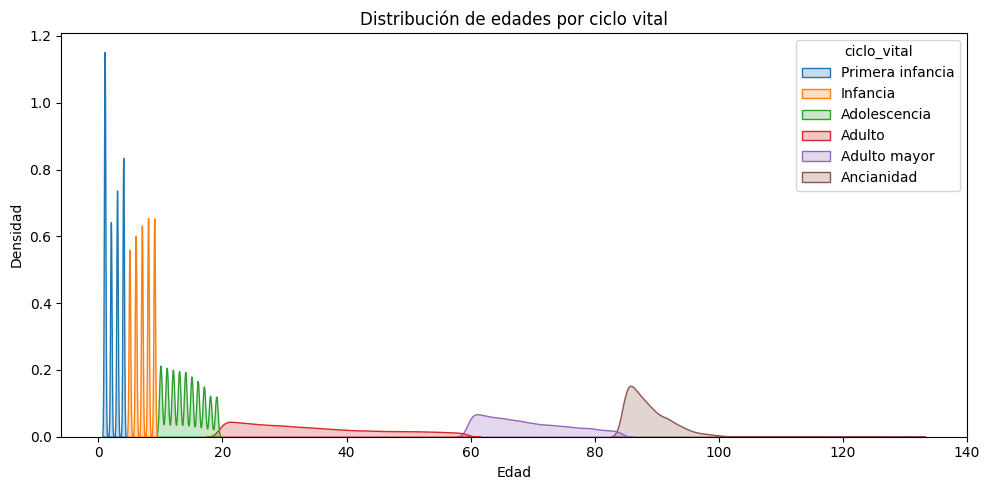

C:\Users\TAWTOCA\AppData\Local\Temp\ipykernel_23636\1163753633.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=grupo, y=variable, palette="Set2")


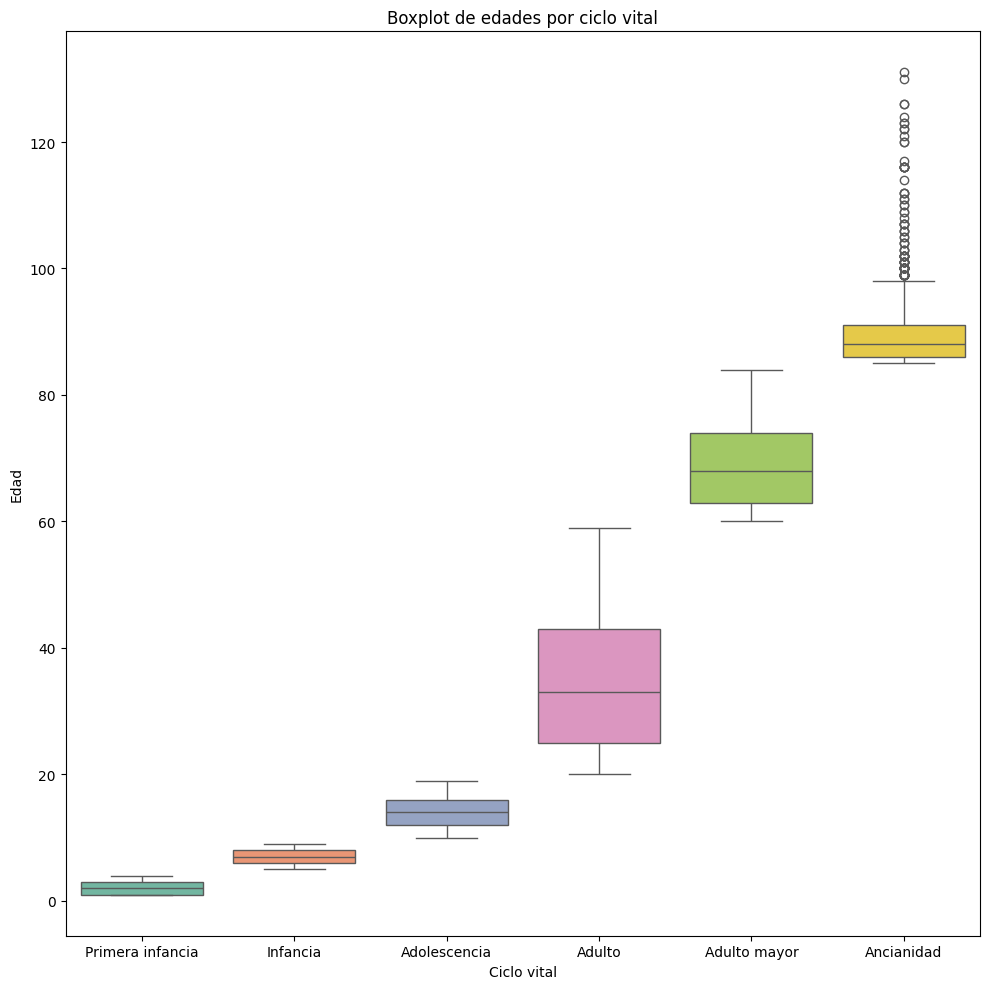

In [15]:
def graficos(df, variable, grupo):
    """
    Genera:
    1. Histograma + densidad global
    2. Densidad por ciclo vital
    3. Boxplot por ciclo vital
    """

    # --- 2. Densidad por ciclo vital ---
    plt.figure(figsize=(10,5))
    sns.kdeplot(data=df, x=variable, hue=grupo, common_norm=False, fill=True)
    plt.title("Distribución de edades por ciclo vital")
    plt.xlabel("Edad")
    plt.ylabel("Densidad")
    plt.tight_layout()
    plt.show()

    # --- 3. Boxplot por ciclo vital ---
    plt.figure(figsize=(10,10))
    sns.boxplot(data=df, x=grupo, y=variable, palette="Set2")
    plt.title("Boxplot de edades por ciclo vital")
    plt.xlabel("Ciclo vital")
    plt.ylabel("Edad")
    plt.tight_layout()
    plt.show()

graficos(df_edad, variable="edad_años", grupo="ciclo_vital")

Los resultados de las pruebas de normalidad (D’Agostino K² y Shapiro-Wilk) indican que en todos los grupos de ciclo vital la distribución de la edad difiere significativamente de la normalidad (p-valor = 0.0), por lo que los datos no cumplen con el supuesto de normalidad. Esto se confirma visualmente en las distribuciones de densidad, donde se observan formas marcadamente asimétricas y concentraciones específicas según el rango etario definido. En el caso de la primera infancia, infancia y adolescencia, las distribuciones se concentran en valores bajos de edad con picos bien definidos, mientras que en la adultez, adulto mayor y ancianidad, la dispersión es mayor y con colas más largas, reflejando la heterogeneidad en edades dentro de cada grupo.

El boxplot de edades por ciclo vital refuerza estos hallazgos al mostrar una clara progresión en las medianas desde la primera infancia hasta la ancianidad, con incrementos esperados según la categorización. Además, se evidencian rangos intercuartílicos más amplios en los adultos y adultos mayores, lo que denota mayor variabilidad, mientras que en los grupos de menor edad los rangos son estrechos y más homogéneos. En el caso de la ancianidad, aparecen múltiples valores atípicos por encima de los 100 años, lo que podría corresponder a registros excepcionales o posibles errores de digitación. En conjunto, estos resultados confirman que las edades por ciclo vital presentan distribuciones no normales, con patrones diferenciados de concentración y dispersión acordes a la estructura etaria de la población.

### *Variables de Evento*

In [5]:
describir_categorica(df['evento'])
describir_categorica(df['tipo_de_caso'])
describir_categorica(df['hospitalizado'])
describir_categorica(df['muerte'])


📌 Variable: evento
         Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
evento                                                               
Clasico  932798      0.9842   932798      0           1.0         0.0
Grave     15012      0.0158        0  15012           0.0         1.0

-----------------------------------

📌 Variable: tipo_de_caso
                       Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
tipo_de_caso                                                              
Probable               697818      0.7362   688295   9523        0.9864   
Conf. por laboratorio  241645      0.2550   236201   5444        0.9775   
Conf. por nexo           8347      0.0088     8302     45        0.9946   

                       Prop_Grave  
tipo_de_caso                       
Probable                   0.0136  
Conf. por laboratorio      0.0225  
Conf. por nexo             0.0054  

-----------------------------------

📌 Variable: hospitalizado
               Co

Descripción variables evento

### *Variables Espaciales*

In [6]:
describir_categorica(df["area"])
describir_categorica(df['departamento'])


📌 Variable: area
                    Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
area                                                                   
Cabecera municipal  779783      0.8227   767733  12050        0.9845   
Rural disperso       90098      0.0951    88577   1521        0.9831   
Centro Poblado       77929      0.0822    76488   1441        0.9815   

                    Prop_Grave  
area                            
Cabecera municipal      0.0155  
Rural disperso          0.0169  
Centro Poblado          0.0185  

-----------------------------------

📌 Variable: departamento
                         Conteo  Proporción  Clasico  Grave  Prop_Clasico  \
departamento                                                                
VALLE                    159224      0.1680   157096   2128        0.9866   
TOLIMA                    81910      0.0864    80285   1625        0.9802   
SANTANDER                 77715      0.0820    76862    853        0.9890   
ANTIOQUI

En cuanto a la variable área, la gran mayoría de los casos de dengue se concentran en las cabeceras municipales (82,3%), seguidas por el área rural dispersa (9,5%) y en menor medida en los centros poblados (8,2%). Aunque la proporción de dengue grave es baja en los tres contextos, se observa una ligera tendencia a que esta forma sea más frecuente en los centros poblados (1,9%) y en áreas rurales (1,7%) en comparación con las cabeceras municipales (1,6%), lo que podría estar asociado a diferencias en el acceso oportuno a los servicios de salud.

Respecto a la distribución por departamento, los mayores aportes de casos provienen del Valle del Cauca (16,8%), Tolima (8,6%), Santander (8,2%), Antioquia (7,5%) y Meta (7,5%), que en conjunto concentran más de la mitad de los registros. En general, en todos los territorios predomina el dengue clásico, pero se evidencian diferencias en la proporción de casos graves: mientras que departamentos como Quindío (0,7%), Putumayo (0,8%) y Amazonas (0,5%) reportan las proporciones más bajas, otros como Huila (2,6%), Bolívar (2,6%), Magdalena (2,9%) y Bogotá (4,4%) muestran una mayor proporción relativa de formas graves. Este hallazgo sugiere que, aunque los departamentos con mayor número absoluto de casos son los del suroccidente y centro del país, la severidad relativa puede ser más relevante en algunos territorios con menor carga total, lo que resalta la importancia de analizar tanto la magnitud como la gravedad de la enfermedad en las distintas regiones.

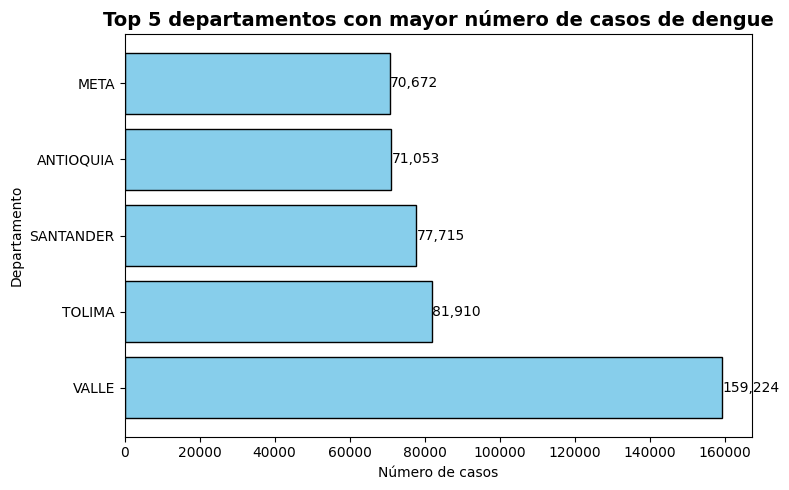

In [7]:
t = pd.DataFrame({
        "Conteo": df['departamento'].value_counts(dropna=False),
        "Proporción": df['departamento'].value_counts(normalize=True, dropna=False).round(4)
})

# Ordenar y seleccionar el top 5
top5 = t.sort_values("Conteo", ascending=False).head(5)

# Gráfico de barras
plt.figure(figsize=(8,5))
bars = plt.barh(top5.index, top5["Conteo"], color="skyblue", edgecolor="black")

for bar in bars:
    xval = bar.get_width()
    plt.text(xval + 100, bar.get_y() + bar.get_height()/2, 
             f"{xval:,}", va="center", fontsize=10)

plt.title("Top 5 departamentos con mayor número de casos de dengue", fontsize=14, weight="bold")
plt.xlabel("Número de casos")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

### *Variables Temporales*

In [8]:
describir_categorica(df["año"])


📌 Variable: año
      Conteo  Proporción  Clasico  Grave  Prop_Clasico  Prop_Grave
año                                                               
2023  128102      0.1352   126382   1720        0.9866      0.0134
2013  125550      0.1325   122441   3109        0.9752      0.0248
2019  124946      0.1318   123598   1348        0.9892      0.0108
2014  107930      0.1139   105311   2619        0.9757      0.0243
2016  100970      0.1065   100071    899        0.9911      0.0089
2015   96403      0.1017    94982   1421        0.9853      0.0147
2020   77244      0.0815    76382    862        0.9888      0.0112
2022   67004      0.0707    65665   1339        0.9800      0.0200
2021   50244      0.0530    49304    940        0.9813      0.0187
2018   44156      0.0466    43637    519        0.9882      0.0118
2017   25261      0.0267    25025    236        0.9907      0.0093

-----------------------------------


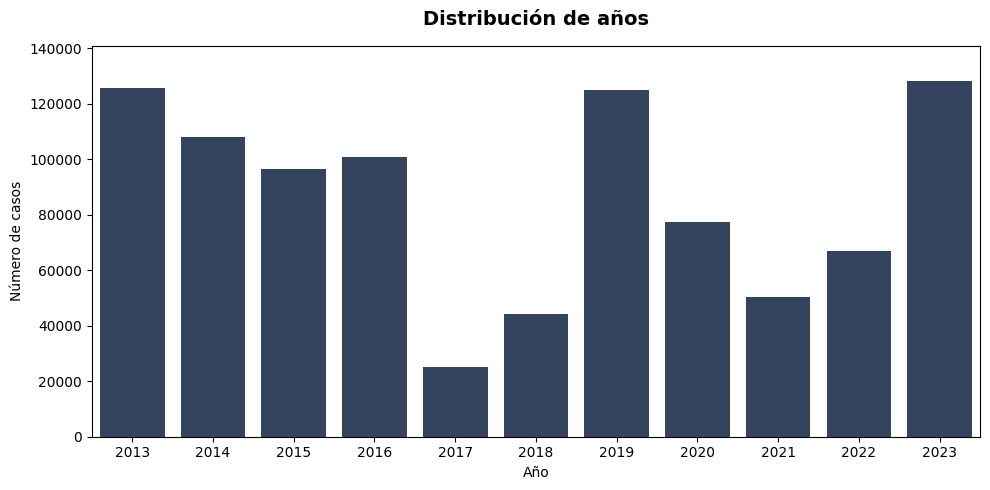

In [9]:
conteo_por_año = df['año'].value_counts(sort=False).sort_index()

    # Crear gráfico
plt.figure(figsize=(10, 5))
sns.barplot(x=conteo_por_año.index.astype(str), y=conteo_por_año.values, color='#2E4265')

plt.title('Distribución de años', fontsize=14, fontweight='bold', pad=15)
plt.xlabel("Año")
plt.ylabel("Número de casos")
plt.xticks(rotation=0)
plt.ylim(0, max(conteo_por_año.values) * 1.1)
plt.tight_layout()
plt.show()


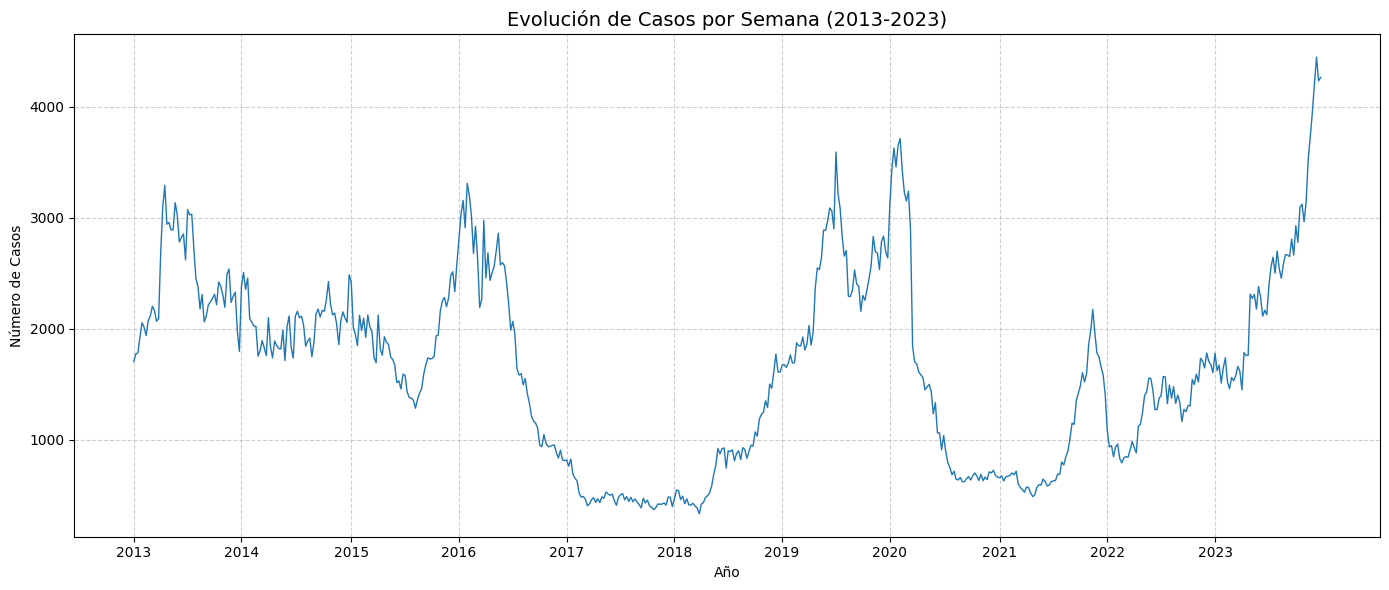

In [10]:
# Agrupar por año y semana
casos_semana = df.groupby(["año", "semana"]).size().reset_index(name="casos")

# Ordenar
casos_semana = casos_semana.sort_values(["año", "semana"]).reset_index(drop=True)

# Crear índice continuo
casos_semana["index"] = range(len(casos_semana))

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(casos_semana["index"], casos_semana["casos"], linewidth=1)

# Marcar solo los años en el eje X
años_unicos = casos_semana["año"].unique()
ticks = [casos_semana[casos_semana["año"] == año].index[0] for año in años_unicos]
plt.xticks(ticks, años_unicos, fontsize=10)

plt.title("Evolución de Casos por Semana (2013-2023)", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Número de Casos")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [16]:

def graficar_evolucion_evento(df, evento, titulo=None):
    """
    Grafica la evolución semanal de casos de un evento específico (ej. 210: clásico, 220: grave).
    El eje x solo muestra el año en la semana 1.
    """

    # === 1. Asegurar tipos ===
    df["semana"] = df["semana"].astype(int)
    df["año"] = df["año"].astype(int)

    # === 2. Filtrar por evento ===
    df_evento = df[df["evento"] == evento]

    # === 3. Agrupar por semana y año ===
    agg = df_evento.groupby(["año", "semana"]).size().reset_index(name="casos")

    # === 4. Crear etiqueta semana-año ===
    agg["semana_año"] = agg["semana"].astype(str) + "-" + agg["año"].astype(str).str[-2:]

    # === 5. Ordenar cronológicamente ===
    agg = agg.sort_values(["año", "semana"]).reset_index(drop=True)

    # === 6. Graficar línea ===
    plt.figure(figsize=(18,6))
    plt.plot(agg["semana_año"], agg["casos"], marker="", linestyle="-")

    # === 7. Generar título automático ===
    if titulo is None:
        if evento == 210:
            titulo = "Evolución semanal de casos de Dengue clásico (2013–2023)"
        elif evento == 220:
            titulo = "Evolución semanal de casos de Dengue grave (2013–2023)"
        else:
            titulo = f"Evolución semanal de casos - Evento {evento} (2013–2023)"

    plt.title(titulo)
    plt.xlabel("Año")
    plt.ylabel("Número de casos")

    # === 8. Etiquetas del eje x solo en semana 1 ===
    xticks_pos = agg[agg["semana"] == 1].index  # posiciones en el DataFrame
    xticks_labels = agg.loc[agg["semana"] == 1, "año"]  # solo el año
    plt.xticks(xticks_pos, xticks_labels, rotation=45, fontsize=9)

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()



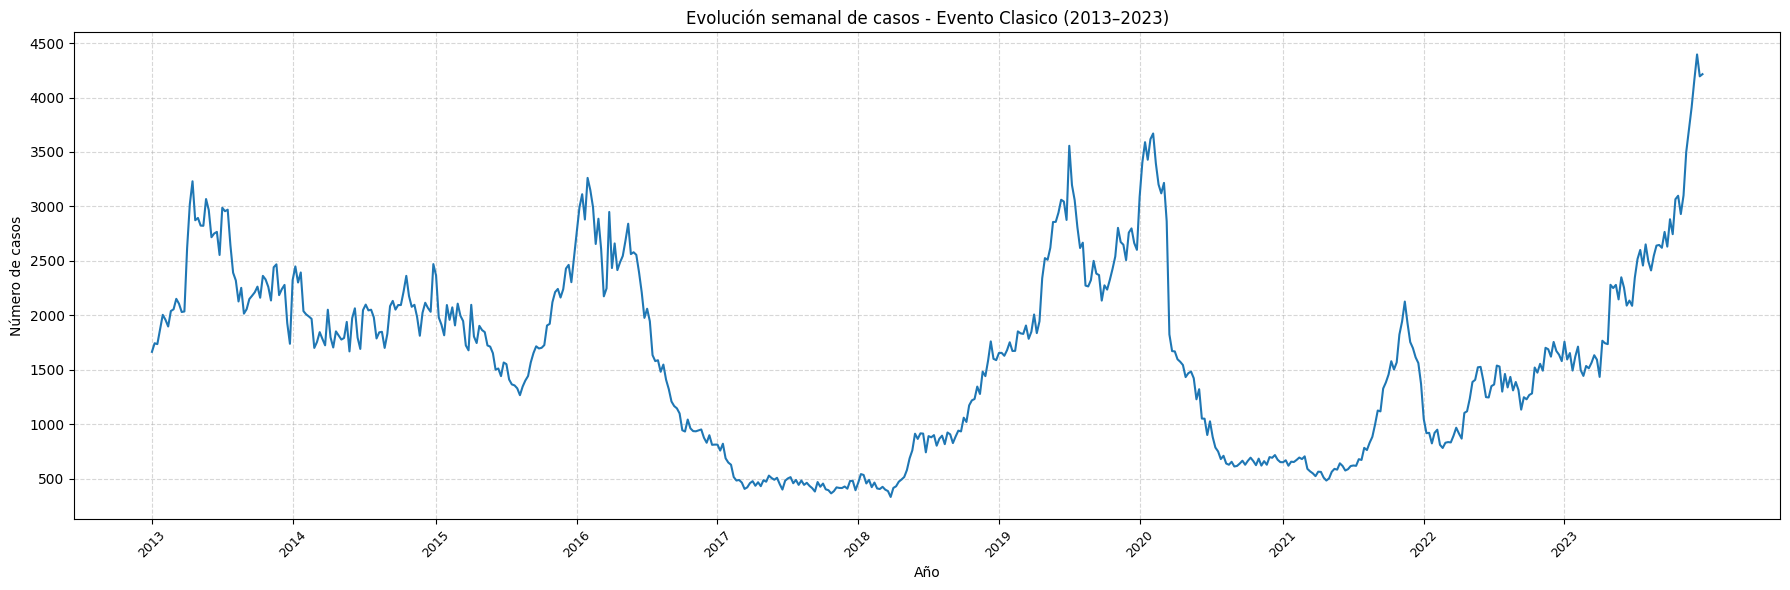

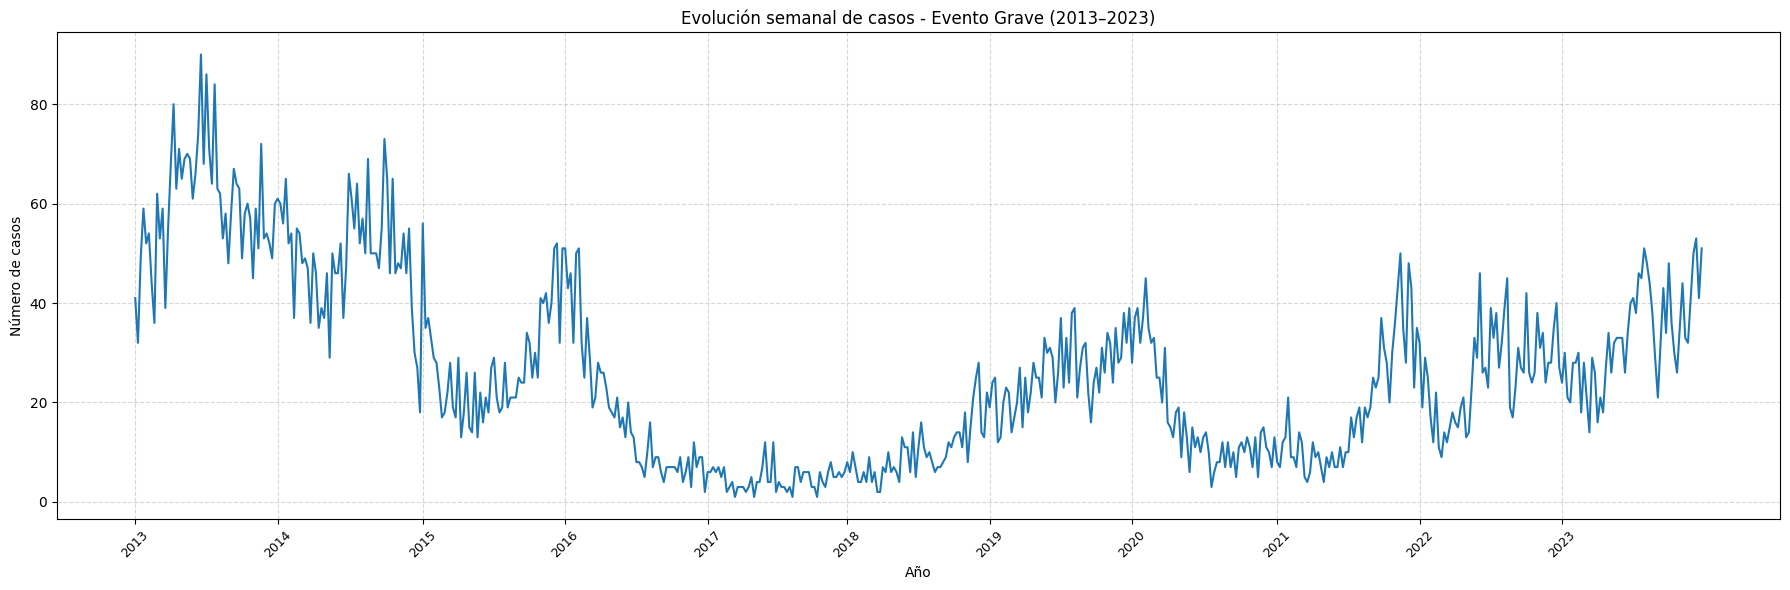

In [17]:
graficar_evolucion_evento(df, evento='Clasico')
graficar_evolucion_evento(df, evento='Grave')

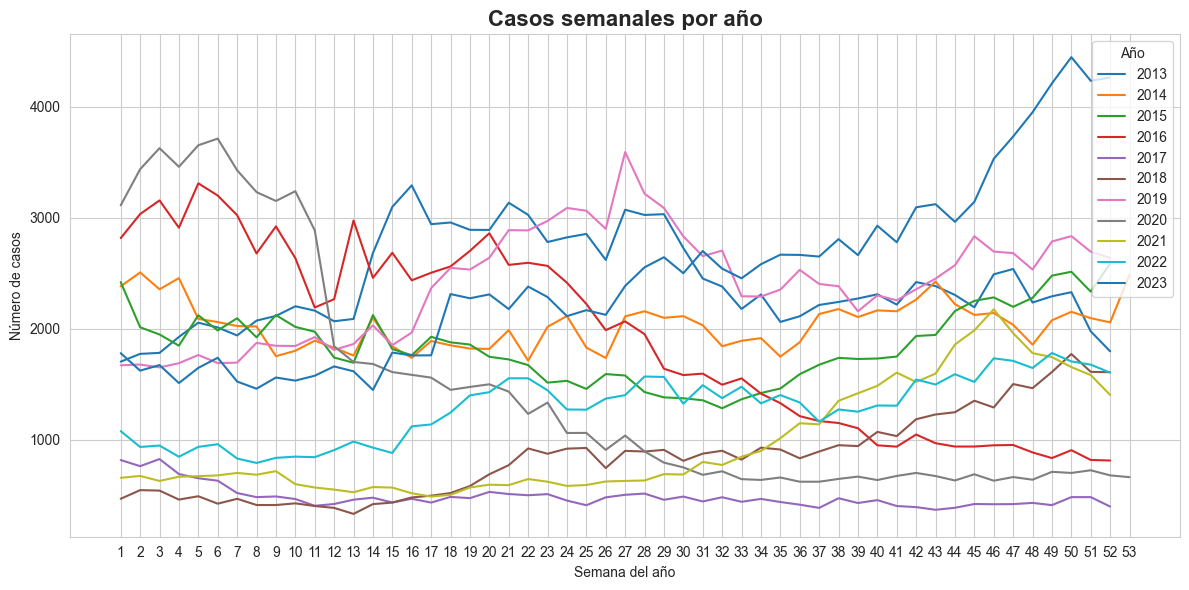

In [19]:
# Contar casos por semana y año
conteo_semanal = df.groupby(['año', 'semana']).size().reset_index(name='casos')

def graficar_casos_semanales_por_año(df_conteo, nombre_grafico="Casos semanales por año"):
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")

    # Graficar cada año como una línea
    for año in sorted(df_conteo['año'].unique()):
        datos_año = df_conteo[df_conteo['año'] == año]
        plt.plot(datos_año['semana'], datos_año['casos'], label=str(año))

    plt.title(nombre_grafico, fontsize=16, fontweight='bold')
    plt.xlabel("Semana del año")
    plt.ylabel("Número de casos")
    plt.xticks(range(1, 54))  # Semanas ISO van de 1 a 53
    plt.legend(title="Año")
    plt.tight_layout()
    plt.show()

graficar_casos_semanales_por_año(conteo_semanal)

In [21]:
# Agrupar y pivotear
conteo_semanal_semanal = df.groupby(['año', 'semana']).size().reset_index(name='casos')
tabla_pivot = conteo_semanal.pivot(index='año', columns='semana', values='casos').fillna(0).astype(int)
tabla_pivot.loc['Total_semana'] = tabla_pivot.sum(axis=0)
# Mostrar la tabla
tabla_pivot

semana           1      2      3      4      5      6      7      8      9   \
año                                                                           
2013           1705   1775   1784   1928   2056   2013   1941   2075   2117   
2014           2384   2509   2357   2458   2090   2062   2026   2022   1754   
2015           2422   2015   1950   1849   2123   1986   2096   1924   2125   
2016           2818   3035   3158   2912   3312   3202   3025   2680   2924   
2017            818    763    827    692    654    632    521    484    490   
2018            469    547    543    462    492    425    469    413    413   
2019           1672   1679   1653   1691   1765   1692   1696   1874   1848   
2020           3114   3439   3629   3461   3655   3715   3430   3233   3153   
2021            658    675    630    668    673    680    702    686    718   
2022           1079    936    949    848    937    961    832    792    838   
2023           1781   1624   1674   1512   1649   1740   1526   1461   1562   
Total_semana  18920  18997  19154  18481  19406  19108  18264  17644  17942   

semana           10  ...     44     45     46     47     48     49     50  \
año                  ...                                                    
2013           2204  ...   2306   2195   2492   2540   2238   2294   2331   
2014           1803  ...   2223   2126   2143   2037   1858   2078   2154   
2015           2018  ...   2161   2253   2284   2199   2280   2480   2515   
2016           2638  ...    940    940    951    954    887    836    907   
2017            467  ...    388    422    420    421    432    412    484   
2018            428  ...   1249   1353   1292   1503   1466   1612   1774   
2019           1846  ...   2574   2835   2697   2683   2535   2788   2836   
2020           3241  ...    634    690    632    665    641    712    702   
2021            601  ...   1859   1987   2176   1962   1782   1746   1656   
2022            849  ...   1592   1522   1735   1712   1648   1783   1707   
2023           1534  ...   2965   3145   3533   3734   3953   4213   4449   
Total_semana  17629  ...  18891  19468  20355  20410  19720  20954  21515   

semana           51     52    53  
año                               
2013           1978   1798     0  
2014           2097   2059  2488  
2015           2336   2589     0  
2016            819    814     0  
2017            484    399     0  
2018           1613   1610     0  
2019           2696   2640     0  
2020            726    680   664  
2021           1584   1405     0  
2022           1678   1606     0  
2023           4236   4266     0  
Total_semana  20247  19866  3152  

[12 rows x 53 columns]

In [22]:
tabla_pivot.to_csv("Conglomerado_casos_col.csv")

In [25]:
# Excluir la columna 'Total_año' si está presente
totales_por_semana = tabla_pivot.loc['Total_semana'].drop('Total_año', errors='ignore')

# Ordenar de mayor a menor
semanas_min = totales_por_semana.sort_values(ascending=True)

# Mostrar las semanas con más casos (por ejemplo, top 5)
semanas_min.head(5)

semana
53     3152
12    15495
33    15980
13    16013
35    16063
Name: Total_semana, dtype: int64

## *Mapas*

In [5]:
shp = gpd.read_file(r"Mapa\COLOMBIA.shp") 
inc210 = pd.read_csv(r"Data\Clasico\tasa_inc_dengue210.csv")
inc220 = pd.read_csv(r"Data\Grave\tasa_inc_dengue220.csv")
casos210 = pd.read_csv(r'Data\Grave\casos_dengue_grave.csv')
casos220 = pd.read_csv(r'Data\Clasico\casos_dengue_clasico.csv')


# Nombres únicos en el dataframe
print('inc210: ',sorted(inc210["departamento"].str.upper().str.strip().unique()))
print('inc220: ',sorted(inc220["departamento"].str.upper().str.strip().unique()))
print('casos210: ',sorted(casos210["departamento"].str.upper().str.strip().unique()))
print('casos220: ',sorted(casos220["departamento"].str.upper().str.strip().unique()))
# Nombres únicos en el shapefile
print('shp: ',sorted(shp["DPTO_CNMBR"].str.upper().str.strip().unique()))


inc210:  ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTA D.C.', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'EXTERIOR', 'GUAINIA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARI?O', 'NORTE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SAN ANDRES', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE DEL CAUCA', 'VAUPES', 'VICHADA']
inc220:  ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ATLANTICO', 'BOGOTA D.C.', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'EXTERIOR', 'GUAINIA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARI?O', 'NORTE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SAN ANDRES', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE DEL CAUCA', 'VAUPES', 'VICHADA']
casos210:  ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ARCHIPIELAGO DE SAN ANDRES', 'ATLANTICO', 'BOGOTA D.C.', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', '

In [6]:
# Diccionario de reemplazos (para estandarizar con el shapefile)
reemplazos = {
    "SAN ANDRES": "ARCHIPIELAGO DE SAN ANDRES",
    "NORTE SANTANDER": "NORTE DE SANTANDER",
    "NARI?O": "NARIÑO"
}

# --- Función para limpiar tasas (elimina EXTERIOR) ---
def limpiar_tasas(df):
    df = df.copy()
    df["departamento"] = (
        df["departamento"]
        .str.upper().str.strip()
        .replace(reemplazos)
    )
    df = df[df["departamento"] != "EXTERIOR"]  # quitar EXTERIOR
    return df

# --- Función para limpiar casos (mantiene EXTERIOR) ---
def limpiar_casos(df):
    df = df.copy()
    df["departamento"] = (
        df["departamento"]
        .str.upper().str.strip()
        .replace(reemplazos)
    )
    return df

# Aplicar
inc210 = limpiar_tasas(inc210)
inc220 = limpiar_tasas(inc220)
casos210 = limpiar_casos(casos210)
casos220 = limpiar_casos(casos220)

# Verificación
print("Departamentos tasas (inc210):", sorted(inc210["departamento"].unique()))
print("Departamentos casos (casos210):", sorted(casos210["departamento"].unique()))
print("Departamentos shapefile:", sorted(shp["DPTO_CNMBR"].str.upper().unique()))


Departamentos tasas (inc210): ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ARCHIPIELAGO DE SAN ANDRES', 'ATLANTICO', 'BOGOTA D.C.', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'GUAINIA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE DE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE DEL CAUCA', 'VAUPES', 'VICHADA']
Departamentos casos (casos210): ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ARCHIPIELAGO DE SAN ANDRES', 'ATLANTICO', 'BOGOTA D.C.', 'BOLIVAR', 'BOYACA', 'CALDAS', 'CAQUETA', 'CASANARE', 'CAUCA', 'CESAR', 'CHOCO', 'CORDOBA', 'CUNDINAMARCA', 'EXTERIOR', 'GUAINIA', 'GUAVIARE', 'HUILA', 'LA GUAJIRA', 'MAGDALENA', 'META', 'NARIÑO', 'NORTE DE SANTANDER', 'PUTUMAYO', 'QUINDIO', 'RISARALDA', 'SANTANDER', 'SUCRE', 'TOLIMA', 'VALLE DEL CAUCA', 'VAUPES', 'VICHADA']
Departamentos shapefile: ['AMAZONAS', 'ANTIOQUIA', 'ARAUCA', 'ARCHIPIELAGO DE SAN ANDRES', 'ATLANTICO', 'BOG

In [38]:
def graficar_tasa_inc_dengue_panel(df, shp, evento=None):
    """
    Grafica la tasa de incidencia de dengue por departamento para los años 2013–2023
    en un panel 3x4 con una escala individual en cada mapa.
    """

    # Normalizar nombres
    df["departamento"] = df["departamento"].str.upper().str.strip()
    shp["DPTO_CNMBR"] = shp["DPTO_CNMBR"].str.upper().str.strip()

    fig, axes = plt.subplots(3, 4, figsize=(25, 12))
    axes = axes.flatten()

    for idx, anio in enumerate(range(2013, 2024)):
        df_anio = df[df["ano"] == anio]

        gdf = shp.merge(df_anio, left_on="DPTO_CNMBR", right_on="departamento", how="left")
        gdf["tasa_inc_100k"] = gdf["tasa_inc_100k"].fillna(0)

        gdf.plot(column="tasa_inc_100k",
                 cmap="Purples",
                 linewidth=0.8,
                 edgecolor="0.8",
                 legend=True,   # barra individual
                 ax=axes[idx],
                 legend_kwds={'label': "Tasa x 100k"})

        axes[idx].set_title(f"{anio}", fontsize=14)
        axes[idx].axis("off")

    # Apagar casillas sobrantes
    for j in range(len(range(2013, 2024)), len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Tasa de incidencia del dengue {evento or 'general'} en Colombia (2013–2023)",
                 fontsize=18, fontweight="bold")
    plt.tight_layout()
    plt.show()
    
def mapa_casos_dengue_panel(df, shp, evento=None):
    anios = list(range(2013, 2024))  # 2013–2023
    fig, axes = plt.subplots(3, 4, figsize=(25, 15))
    axes = axes.flatten()

    for idx, anio in enumerate(anios):
        df_anio = df[(df["ano"] == anio) & (df["departamento"] != "EXTERIOR")]

        gdf = shp.merge(df_anio, left_on="DPTO_CNMBR", right_on="departamento", how="left")
        gdf["casos"] = gdf["casos"].fillna(0)

        gdf.plot(column="casos", cmap="Blues",
                 linewidth=0.8, edgecolor="0.8",
                 legend=True,   # barra individual
                 ax=axes[idx],
                 legend_kwds={'label': "Casos"})

        axes[idx].set_title(f"{anio}", fontsize=14)
        axes[idx].axis("off")

    # Casilla global (última)
    df_total = df[df["departamento"] != "EXTERIOR"].groupby("departamento")["casos"].sum().reset_index()
    gdf_total = shp.merge(df_total, left_on="DPTO_CNMBR", right_on="departamento", how="left")
    gdf_total["casos"] = gdf_total["casos"].fillna(0)

    gdf_total.plot(column="casos", cmap="Blues",
                   linewidth=0.8, edgecolor="0.8",
                   legend=True, ax=axes[-1],
                   legend_kwds={'label': "Total 2013–2023"})

    axes[-1].set_title("Total 2013–2023", fontsize=14)
    axes[-1].axis("off")

    plt.suptitle(f"Casos de dengue {evento or 'general'} en Colombia", fontsize=18)
    plt.tight_layout()
    plt.show()


### *Cantidad de Casos por Evento*

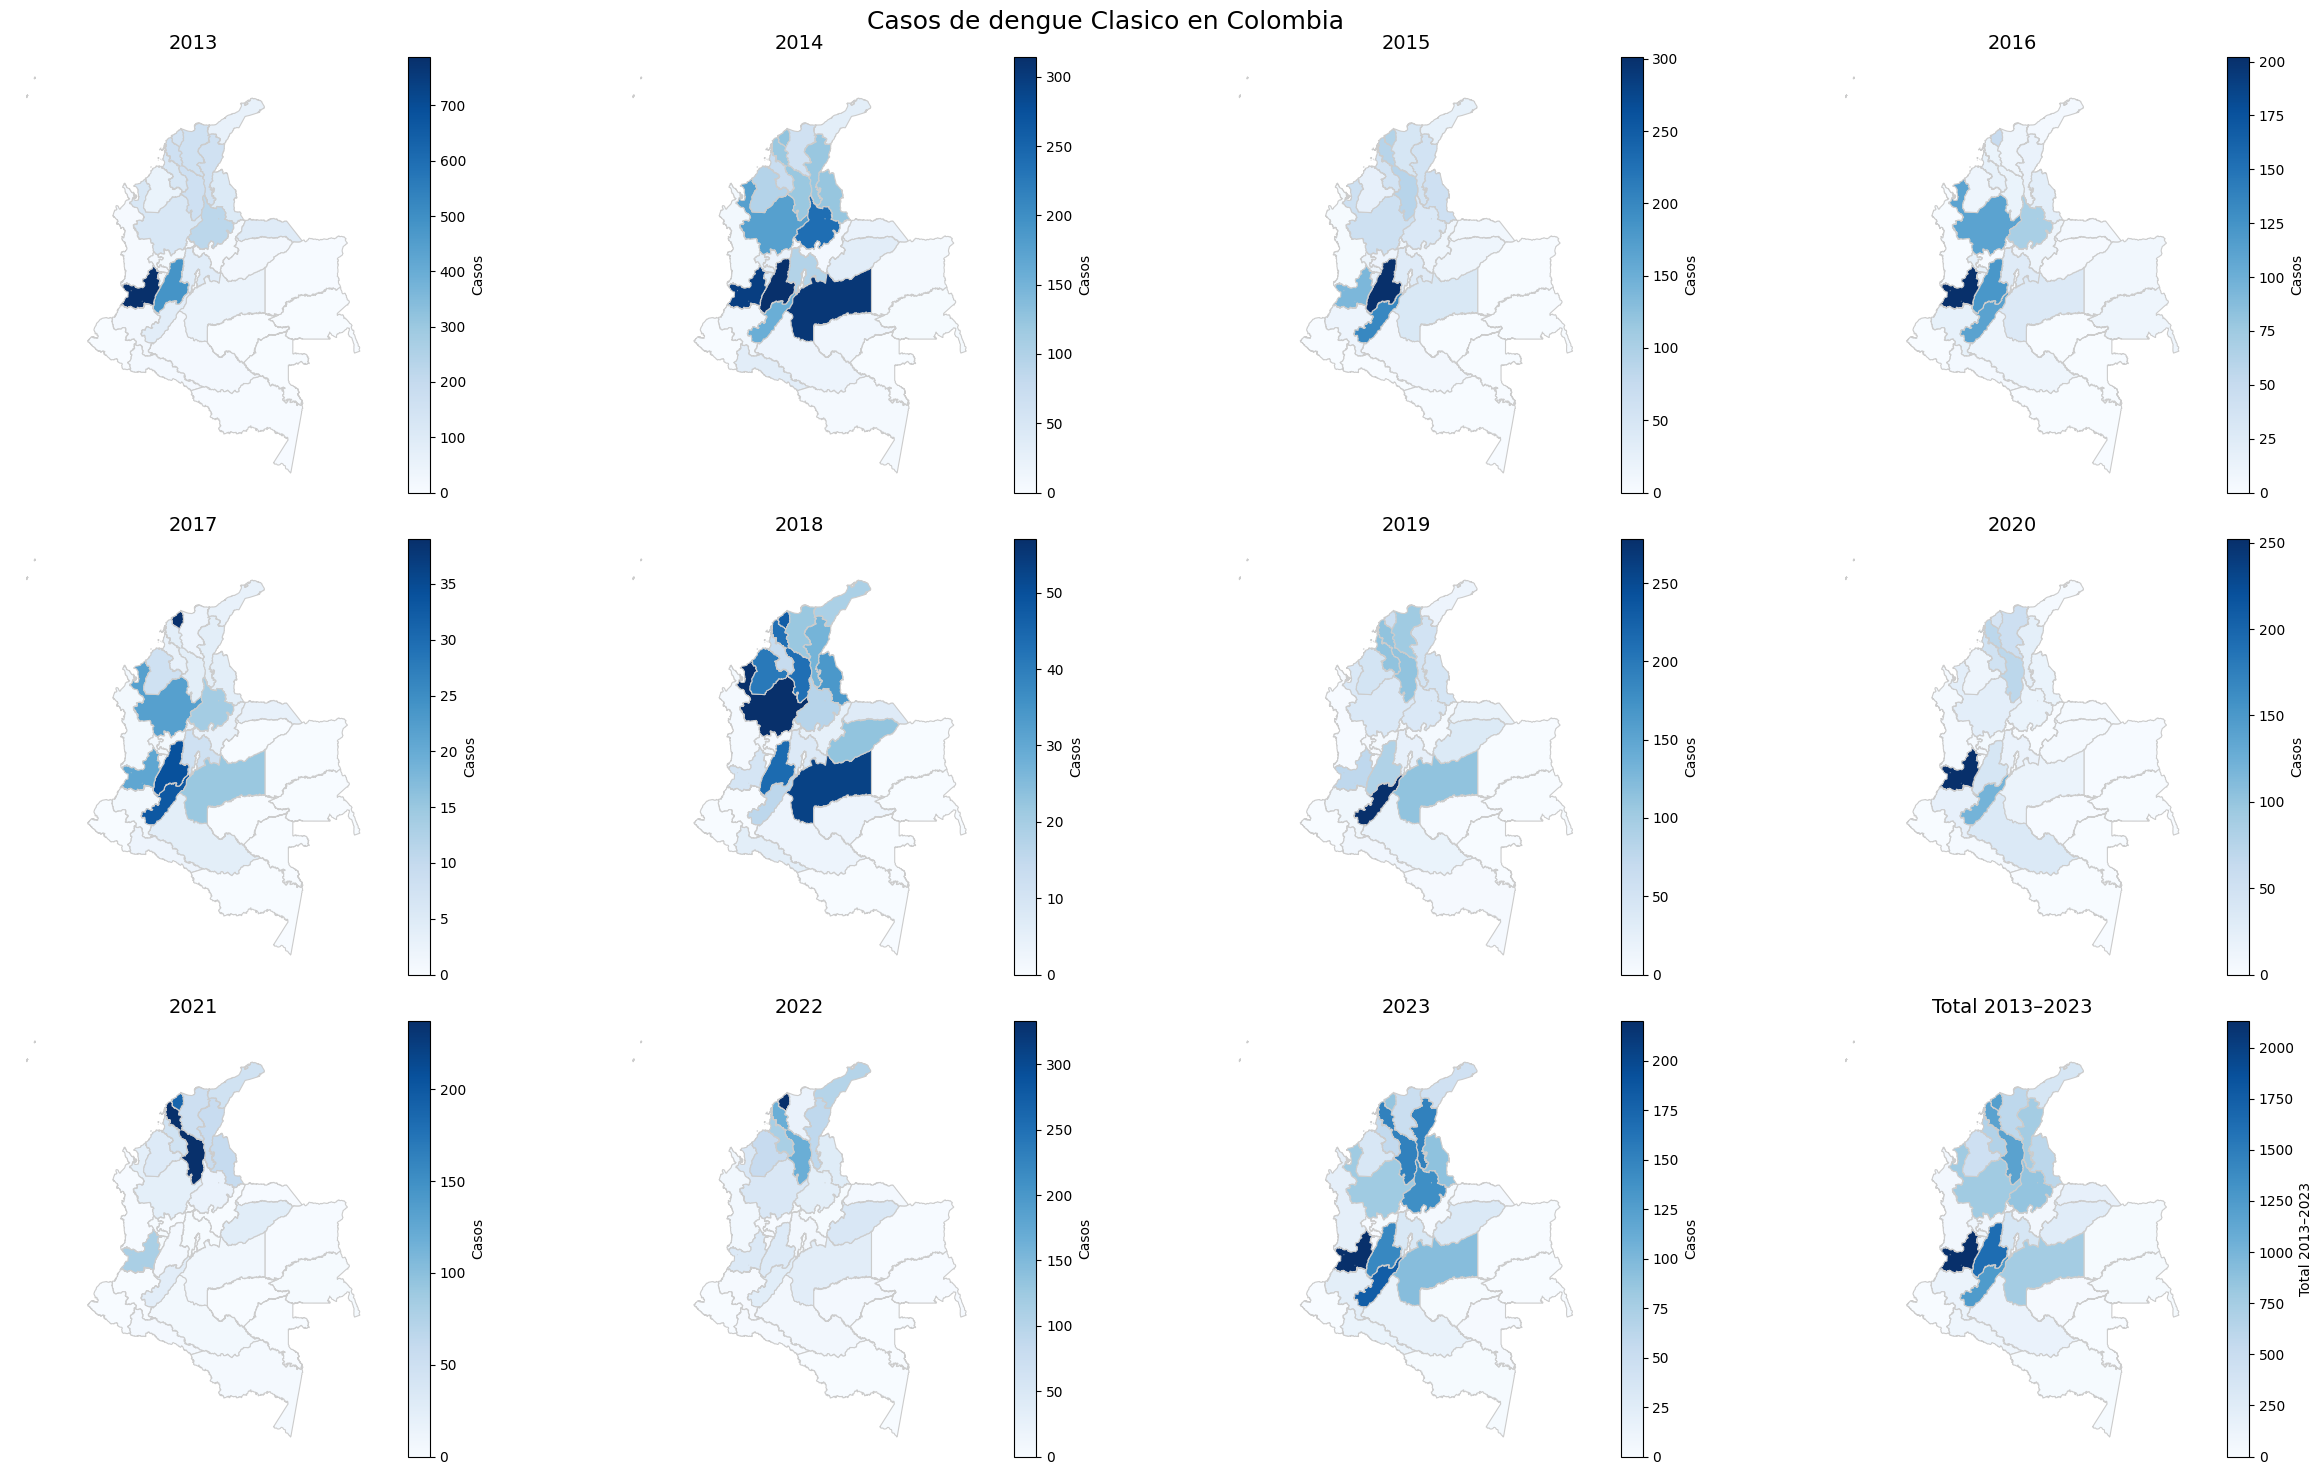

In [39]:
mapa_casos_dengue_panel(casos210, shp, evento='Clasico')

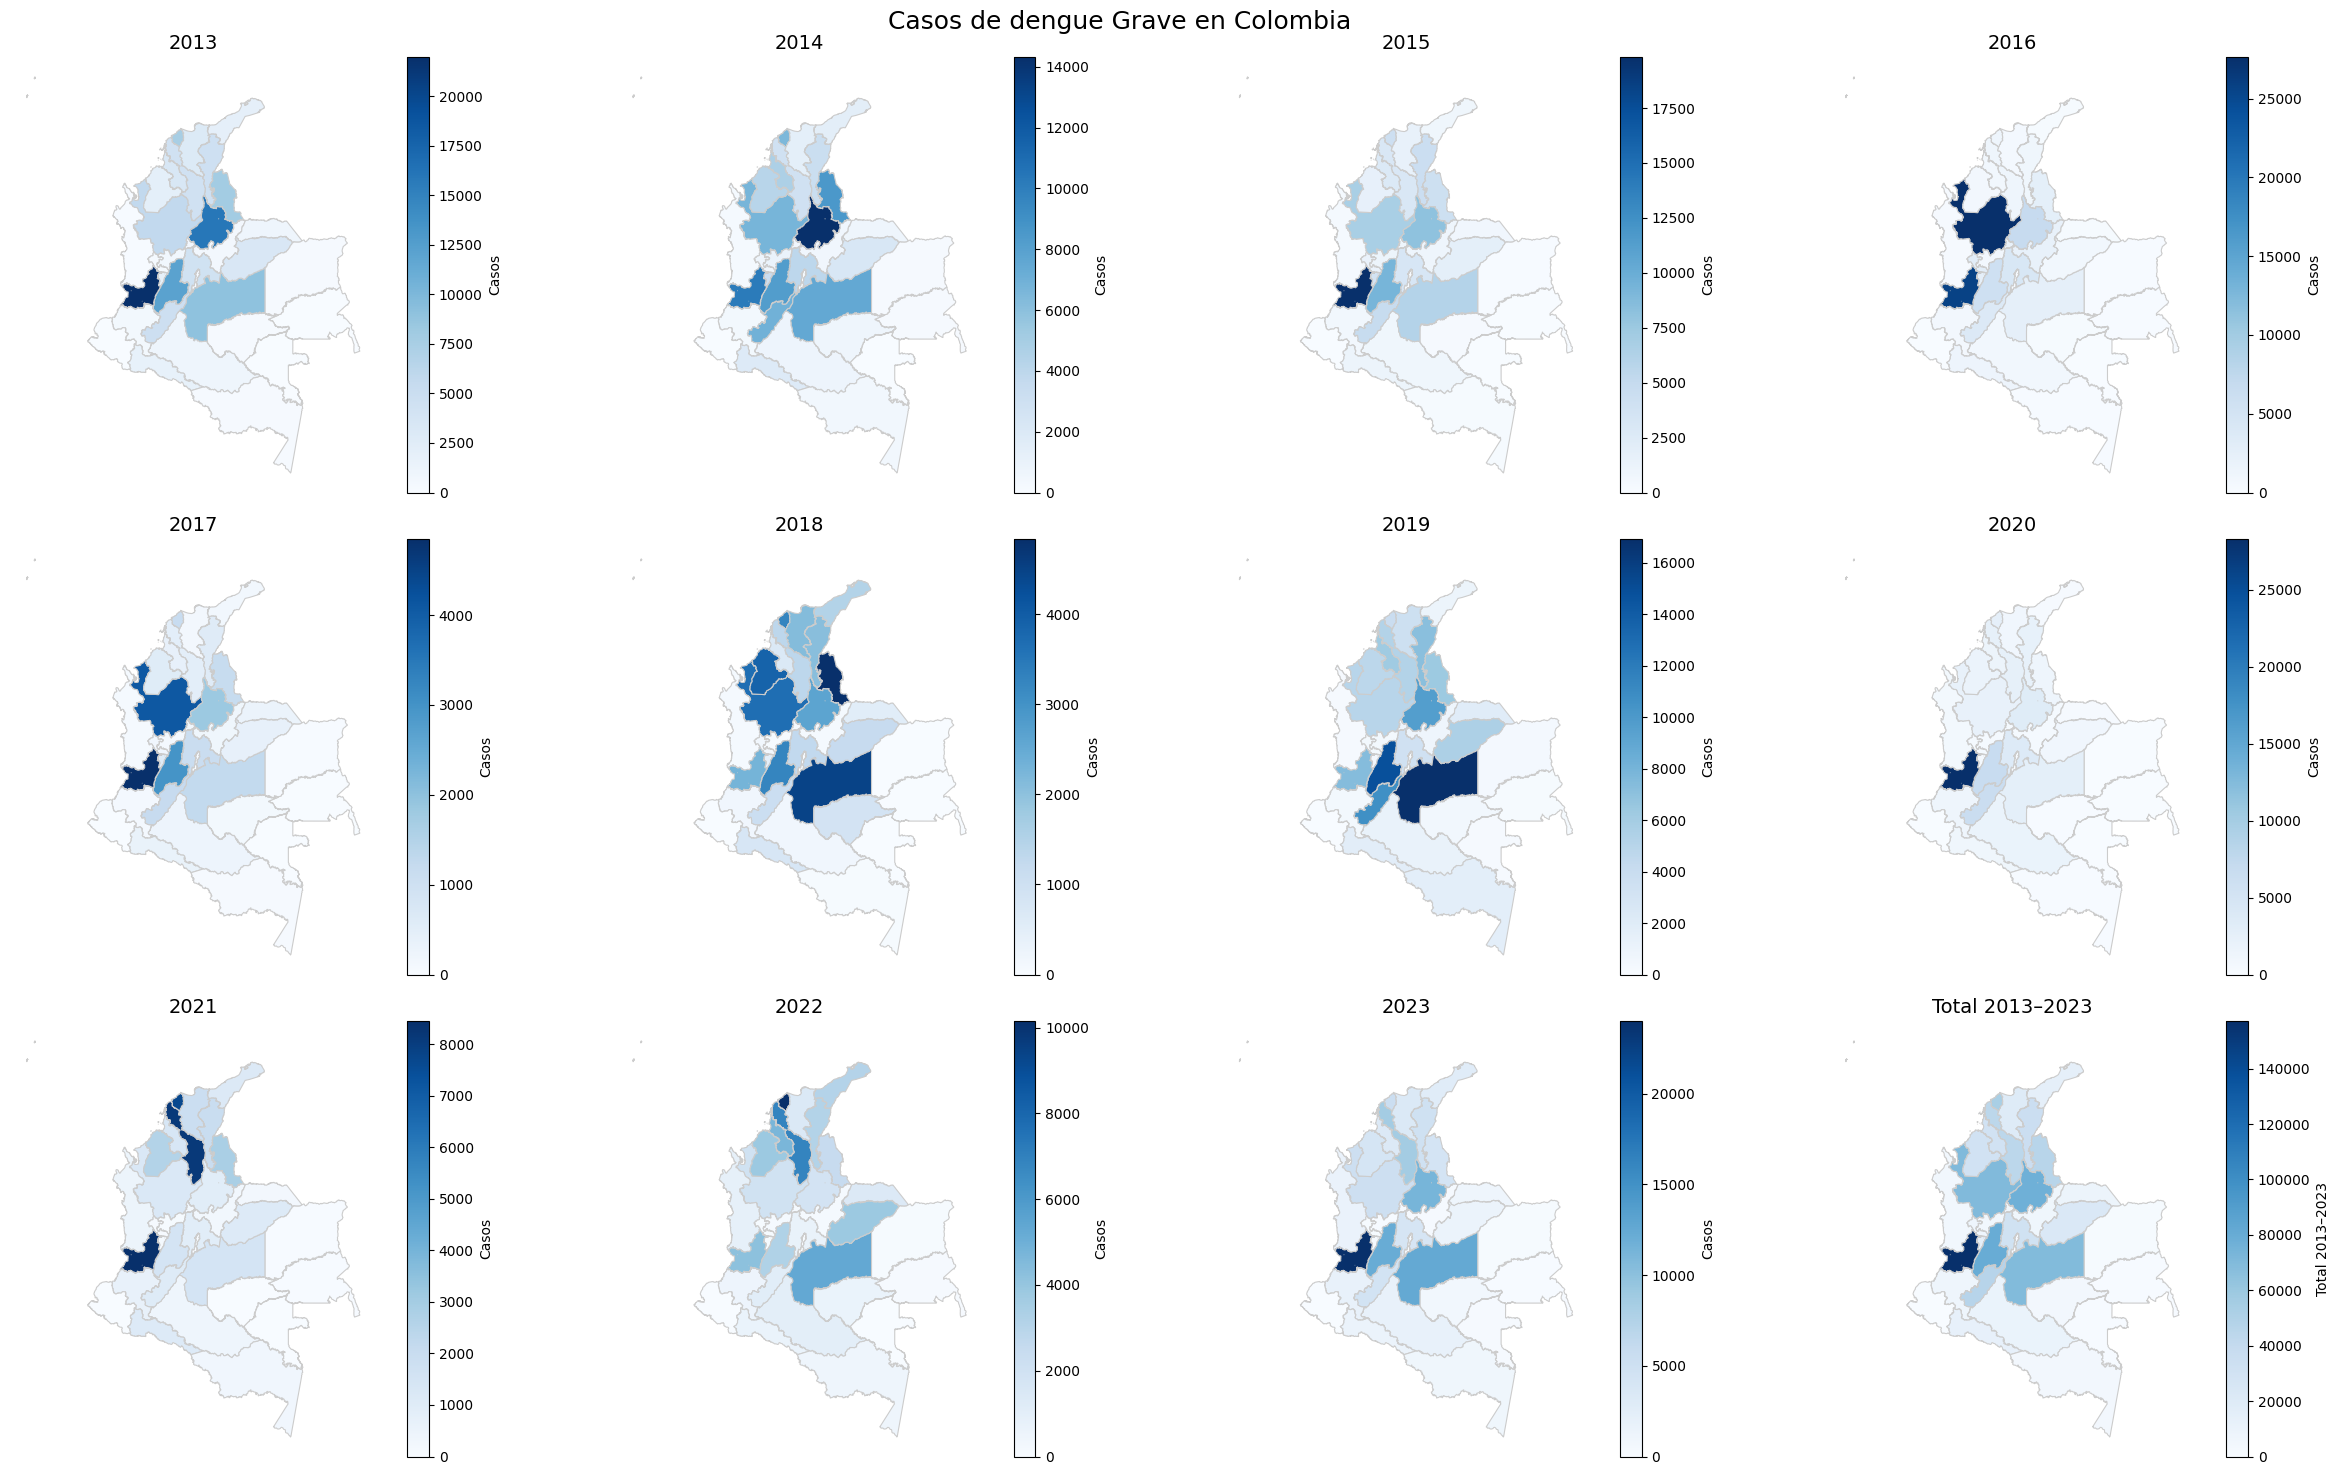

In [40]:
mapa_casos_dengue_panel(casos220, shp, evento='Grave')

### *Tasas de Incidencia*

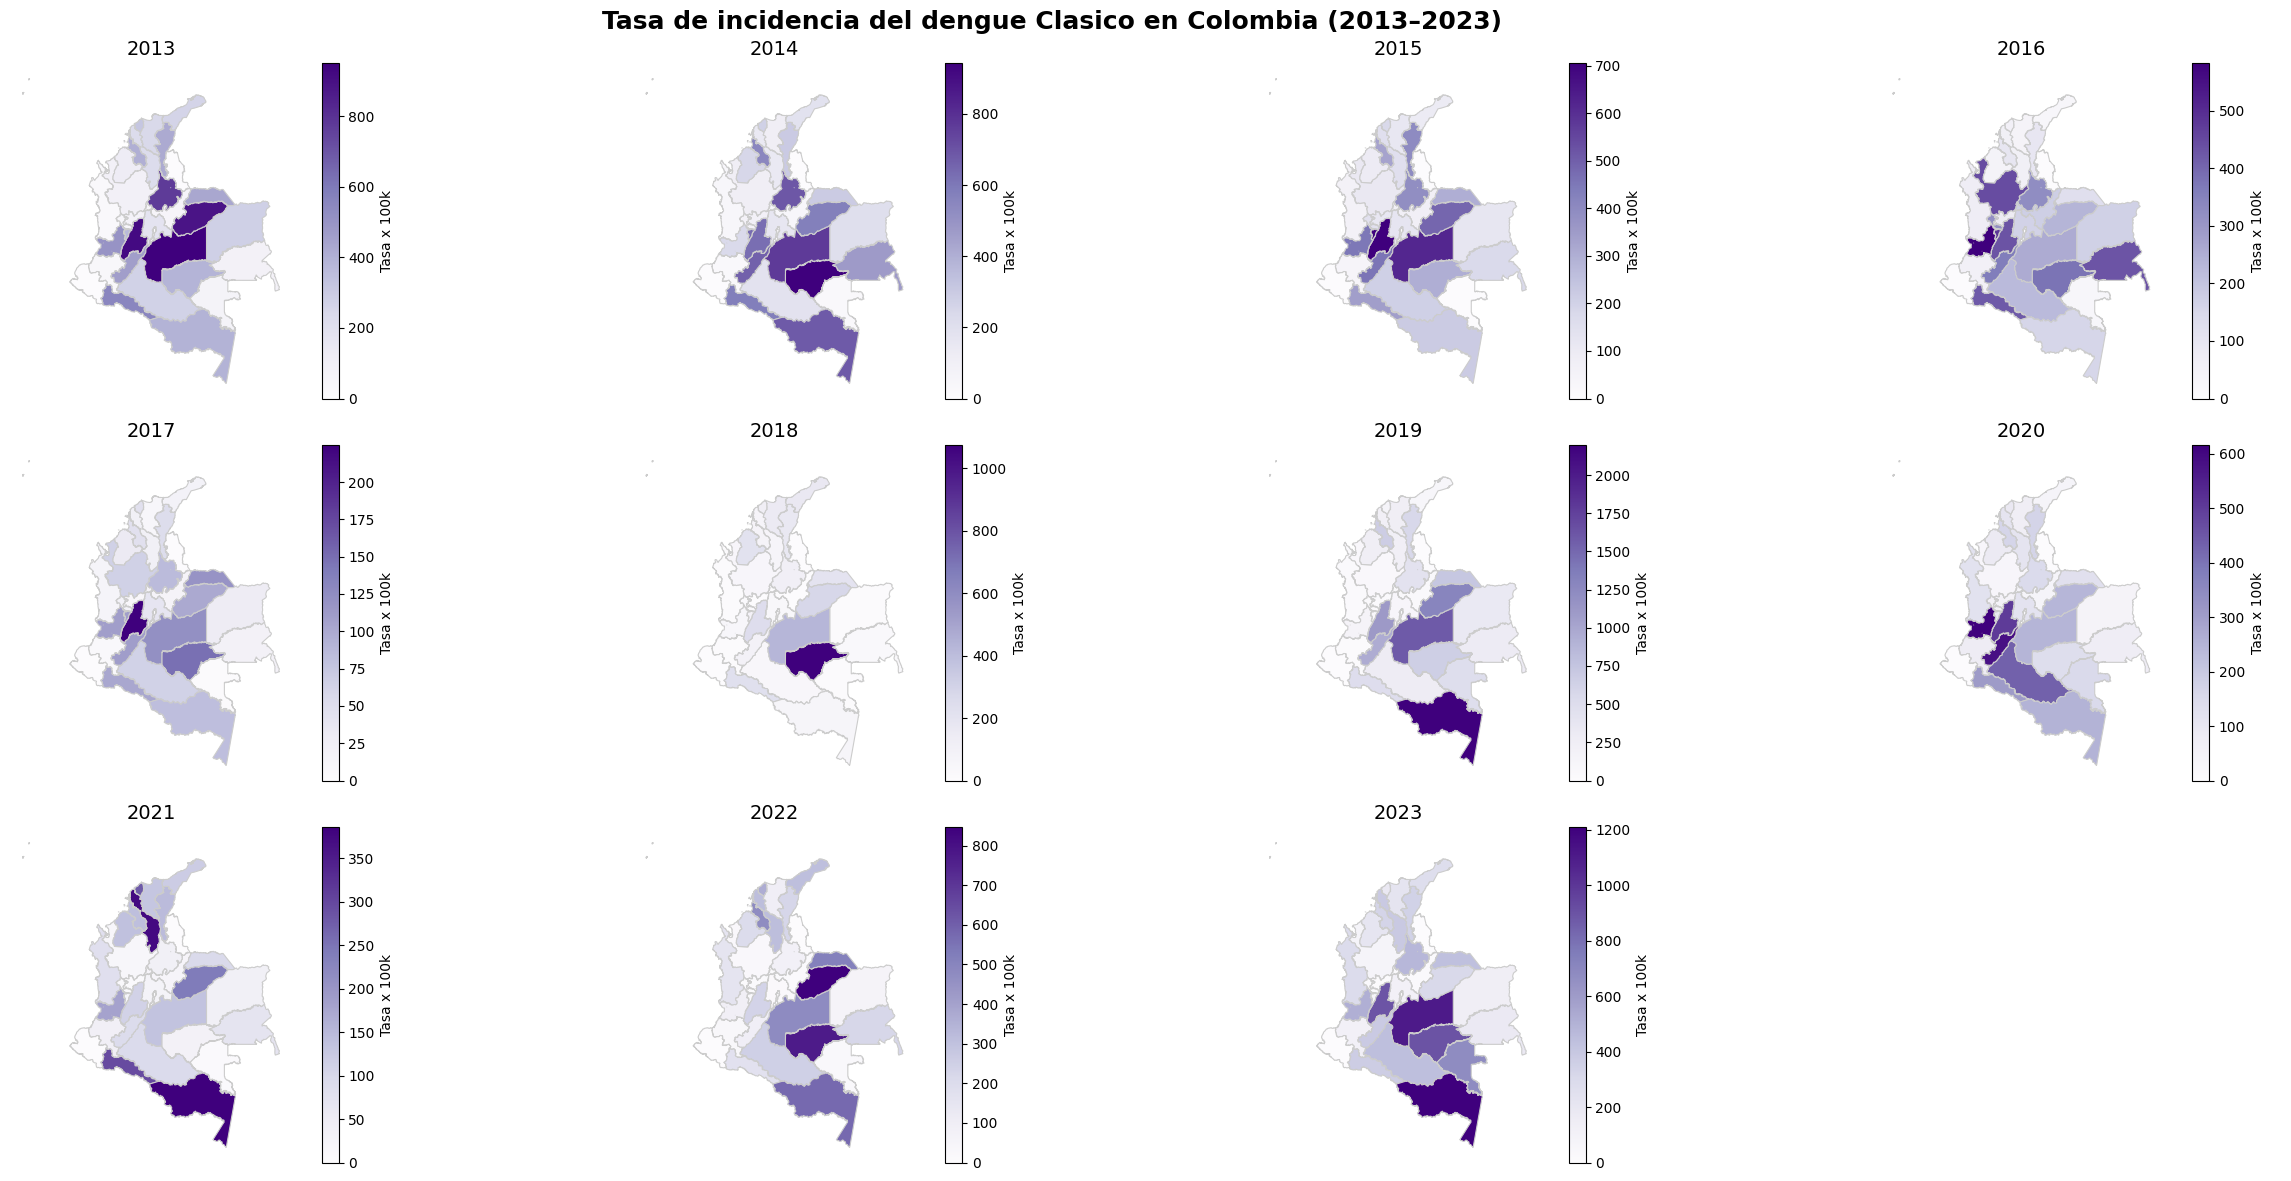

In [33]:
graficar_tasa_inc_dengue_panel(inc210, shp, evento='Clasico')

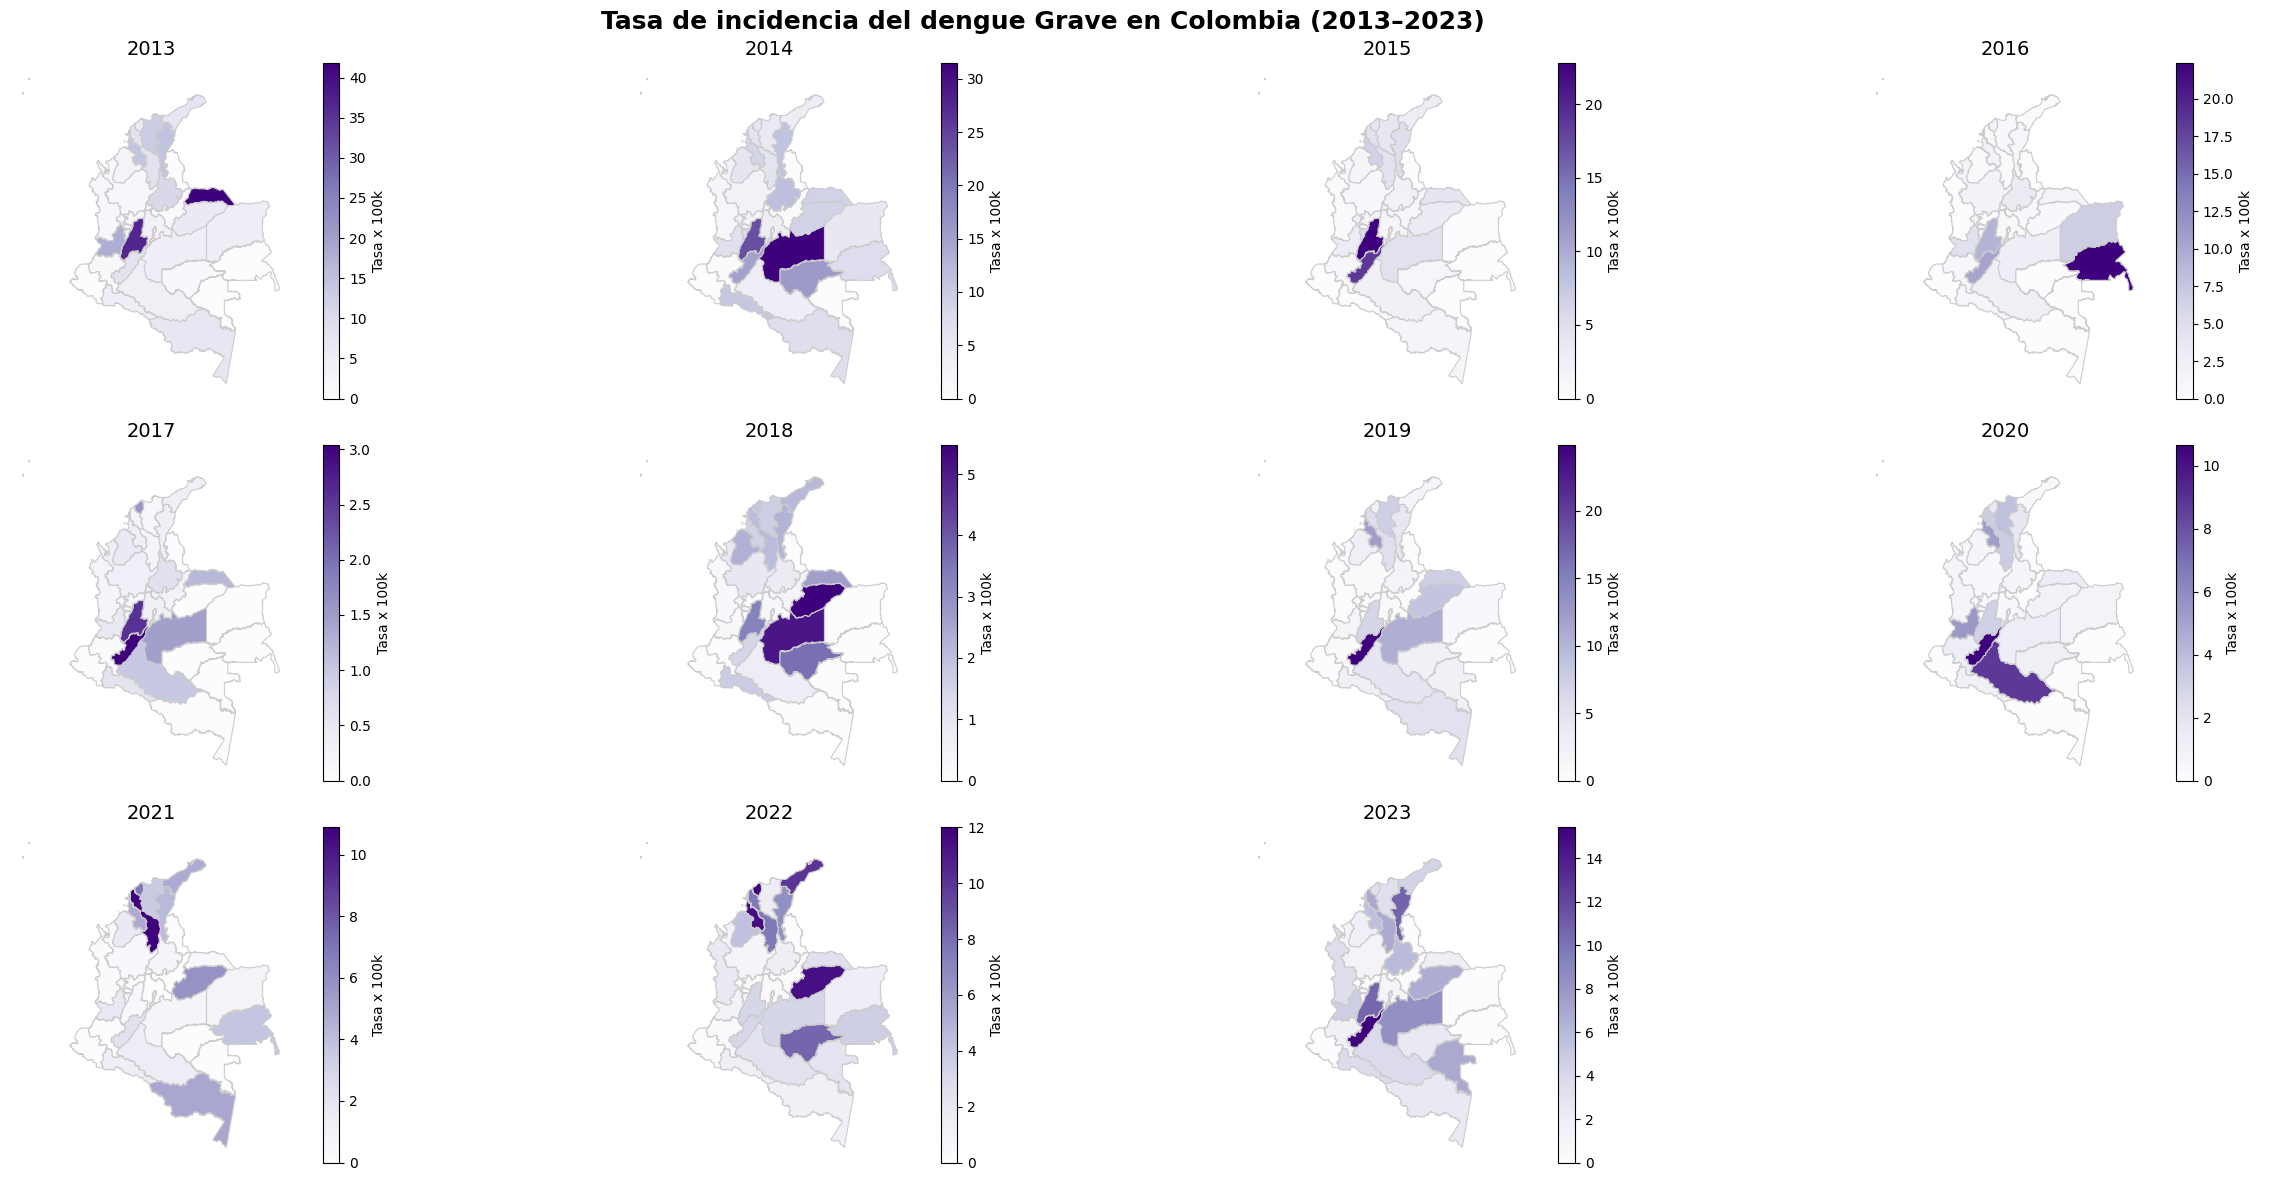

In [34]:
graficar_tasa_inc_dengue_panel(inc220, shp, evento='Grave')

### *REM*

In [10]:
rem_clasico = pd.read_csv(r"Data\Clasico\REM_Clasico_Largo.csv")
rem_grave = pd.read_csv(r"Data\Grave\REM_Grave_Largo.csv")

In [35]:

def graficar_panel_rem(df, shp, evento=None):
    """
    Grafica un panel de mapas del REM de dengue en Colombia por años,
    cada uno con su escala individual.
    
    Parámetros:
        df (pd.DataFrame): datos con columnas [departamento, anio, rem].
        shp (gpd.GeoDataFrame): shapefile de Colombia con columna DPTO_CNMBR.
        evento (str, opcional): tipo de evento ("Clásico", "Grave", etc.).
    """

    # === 1. Normalizar nombres ===
    df["departamento"] = df["departamento"].str.upper().str.strip()
    shp["DPTO_CNMBR"] = shp["DPTO_CNMBR"].str.upper().str.strip()

    # === 2. Lista de años únicos ordenados ===
    anios = sorted(df["anio"].unique())

    # === 3. Crear figure y ejes ===
    ncols = 4
    nrows = (len(anios) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))
    axes = axes.flatten()

    for i, anio in enumerate(anios):
        ax = axes[i]
        df_anio = df[df["anio"] == anio]
        gdf_anio = shp.merge(df_anio, left_on="DPTO_CNMBR", right_on="departamento", how="left")
        gdf_anio["rem"] = gdf_anio["rem"].fillna(0)

        vmin = gdf_anio["rem"].min()
        vmax = gdf_anio["rem"].max()

        # Graficar mapa
        gdf_anio.plot(
            column="rem",
            cmap="Greens",
            linewidth=0.5,
            edgecolor="0.8",
            vmin=vmin, vmax=vmax,
            ax=ax,
            legend=True,
            legend_kwds={"shrink": 0.6, "label": "REM"}
        )

        ax.set_title(str(anio), fontsize=12, fontweight="bold")
        ax.axis("off")

    # Ocultar subplots vacíos
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    # === 4. Título global ===
    titulo = f"REM del dengue {evento or 'general'} en Colombia ({anios[0]}–{anios[-1]})"
    fig.suptitle(titulo, fontsize=16, fontweight="bold")

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


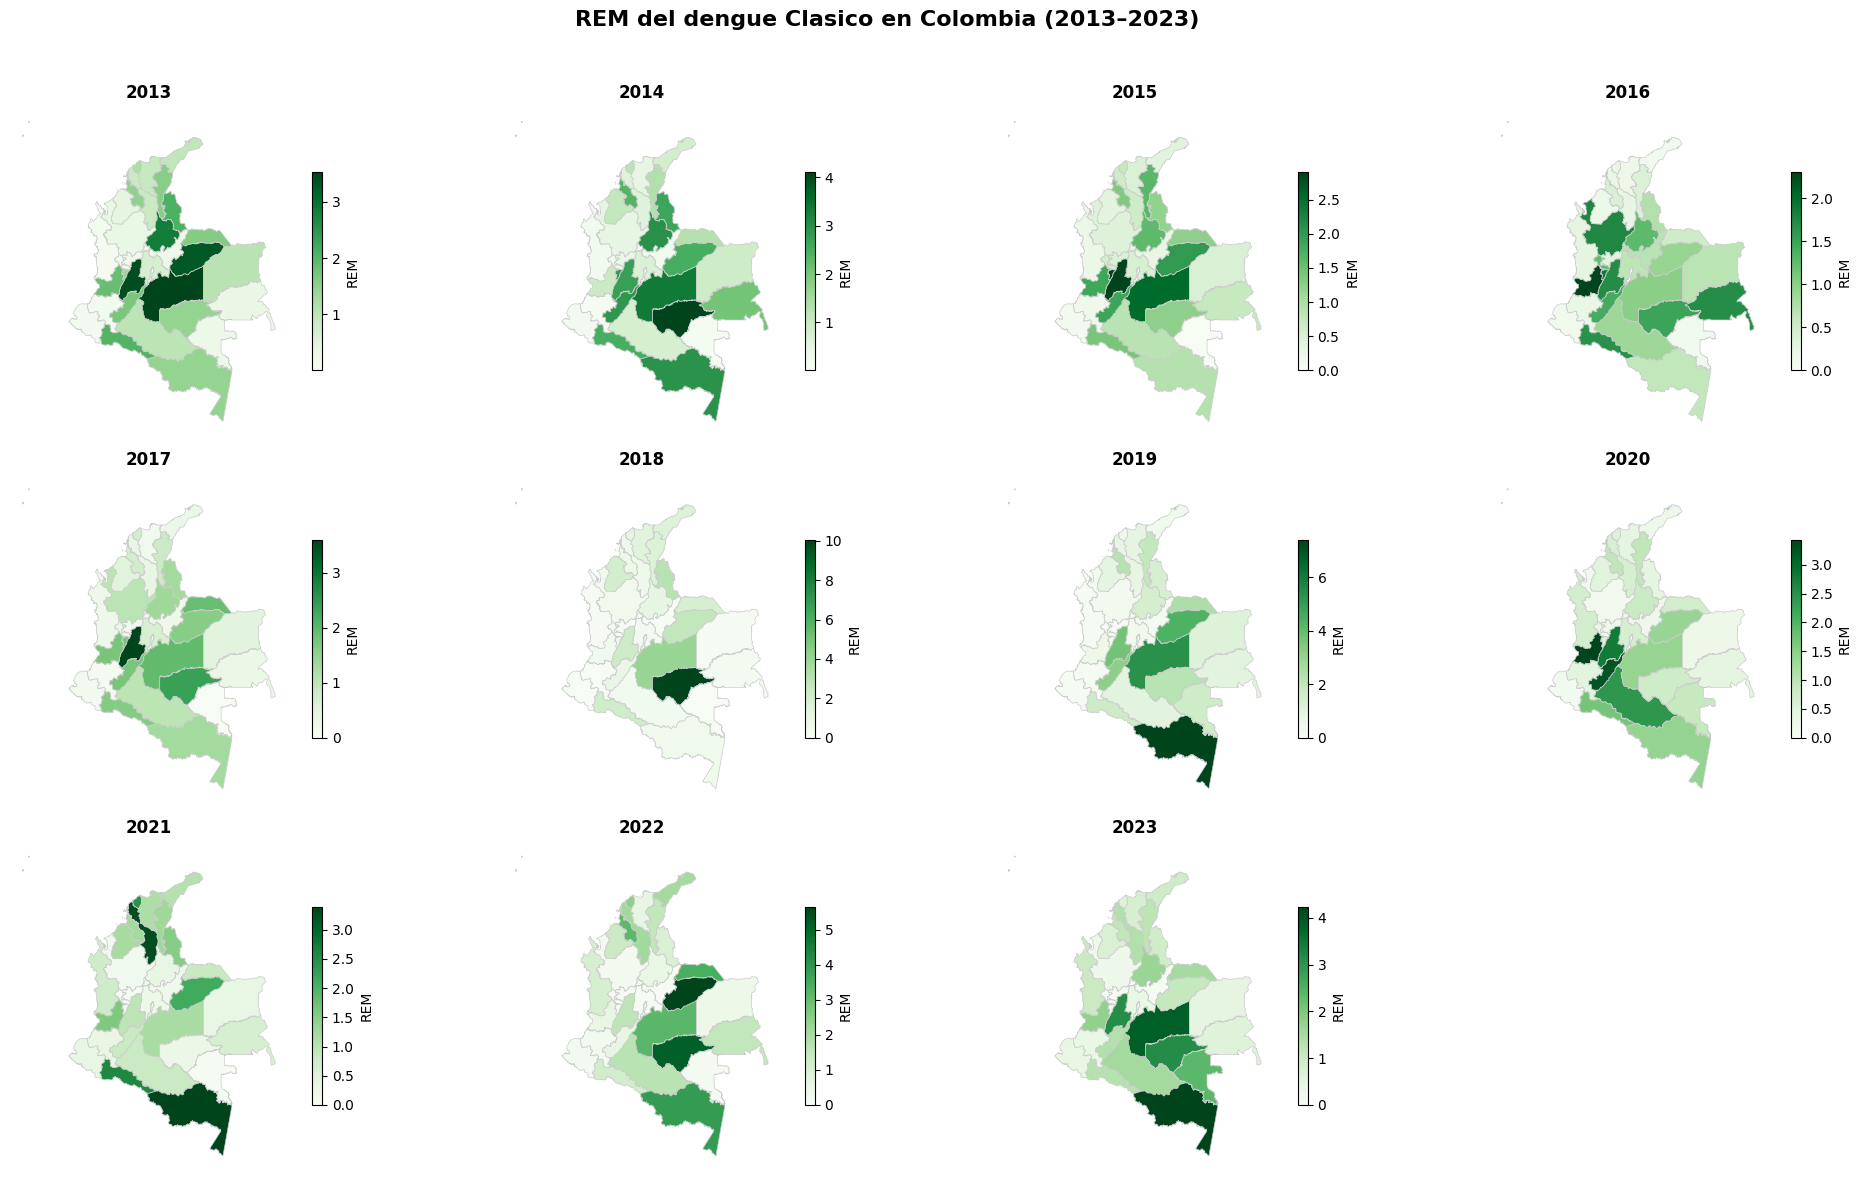

In [36]:
graficar_panel_rem(rem_clasico, shp, evento="Clasico")

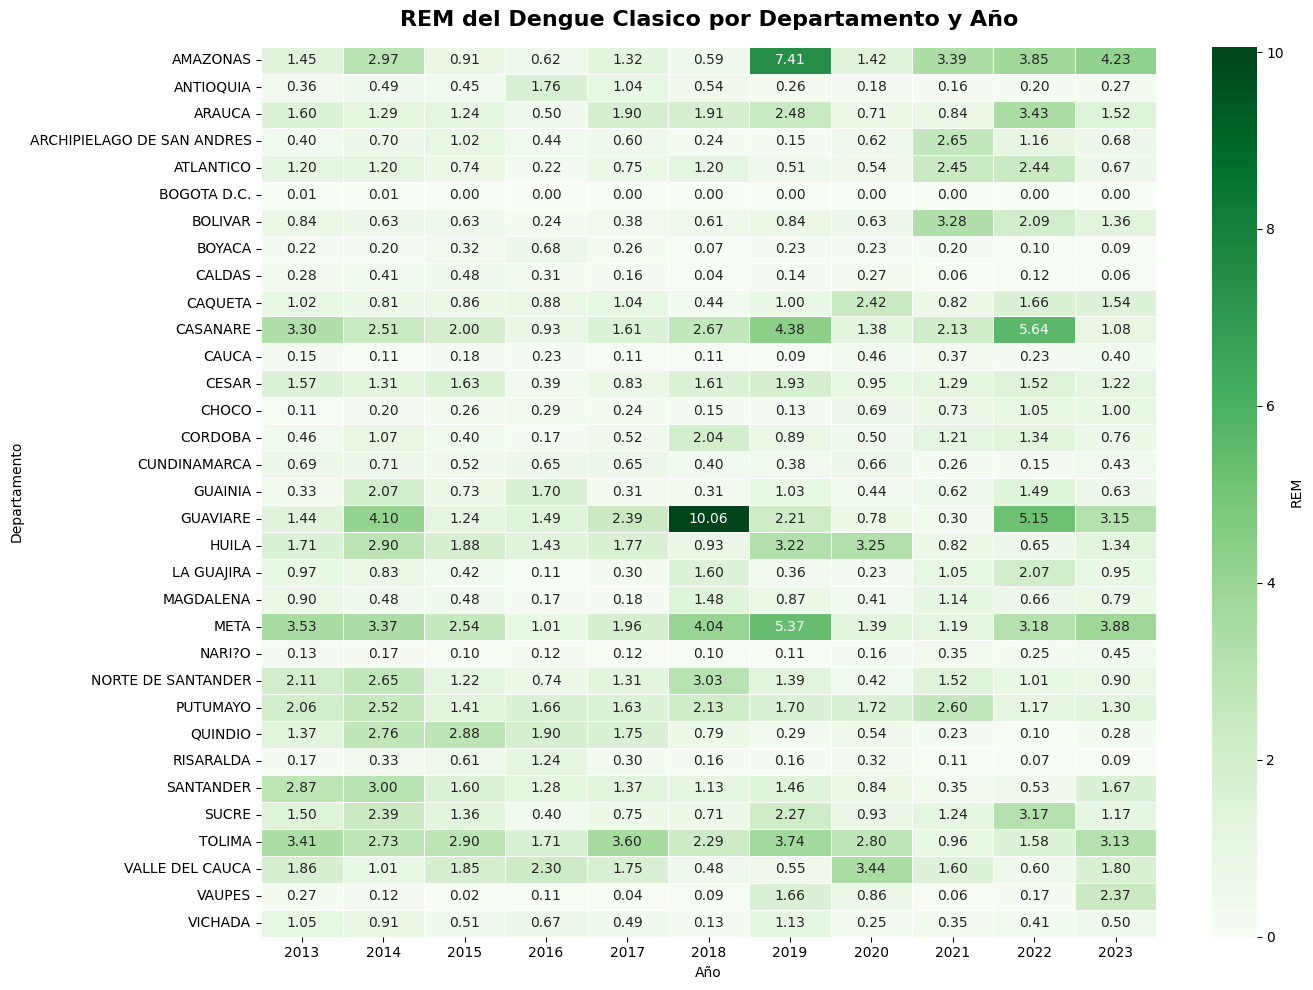

In [22]:
tabla_clasico_rem = rem_clasico.pivot(index="departamento", columns="anio", values="rem").fillna(0)

# === 3. Graficar heatmap ===
plt.figure(figsize=(14, 10))
sns.heatmap(tabla_clasico_rem, cmap="Greens", annot=True, fmt=".2f", linewidths=0.5, cbar_kws={'label': 'REM'})

plt.title("REM del Dengue Clasico por Departamento y Año", fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Año")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()

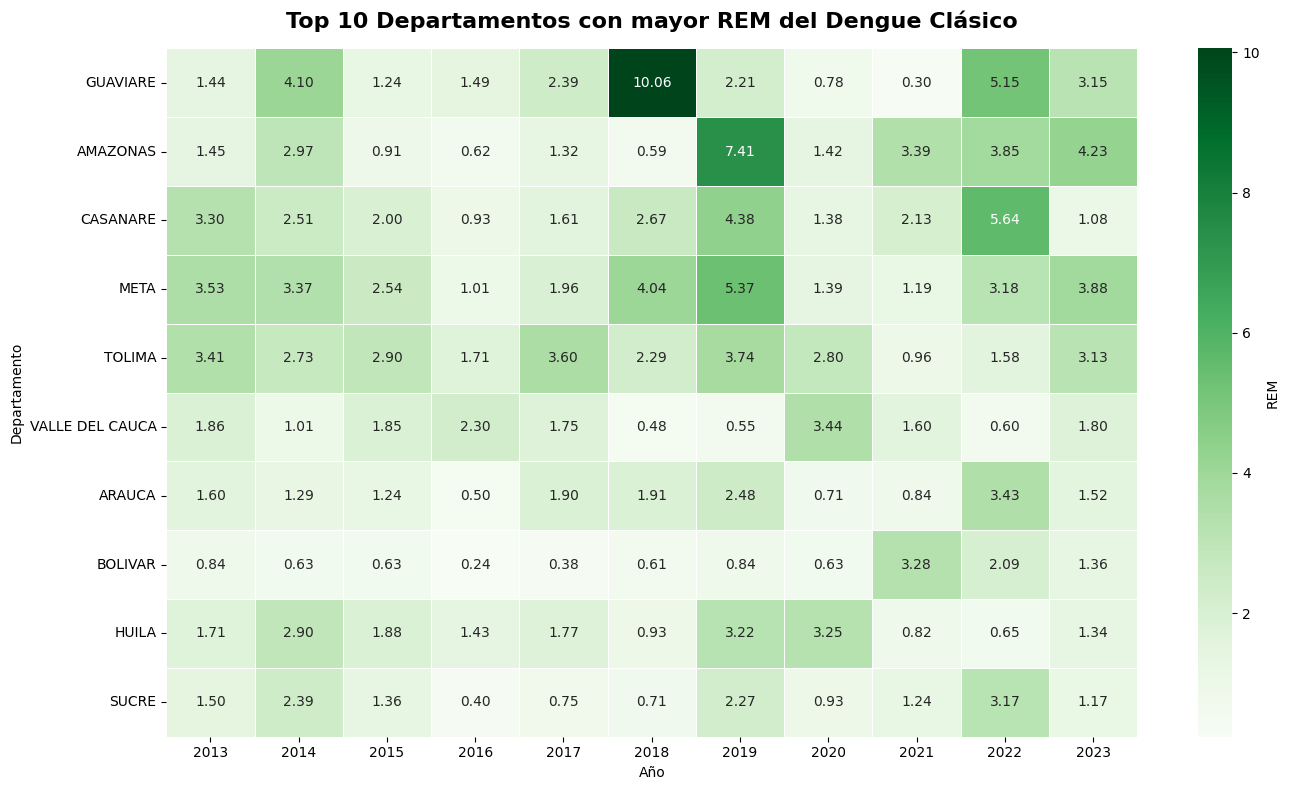

In [23]:


# === 1. Pivotear ===
tabla_clasico_rem = rem_clasico.pivot(
    index="departamento", 
    columns="anio", 
    values="rem"
).fillna(0)

# === 2. Seleccionar top 10 departamentos con mayores valores de REM ===
top10_departamentos = (
    tabla_clasico_rem.max(axis=1)  # máximo de cada depto en todos los años
    .nlargest(10)                  # los 10 más altos
    .index                         # nombres de los deptos
)
tabla_top10 = tabla_clasico_rem.loc[top10_departamentos]

# === 3. Graficar heatmap ===
plt.figure(figsize=(14, 8))
sns.heatmap(
    tabla_top10,
    cmap="Greens",
    annot=True,
    fmt=".2f",              # <-- mostrar con 2 decimales
    linewidths=0.5,
    cbar_kws={'label': 'REM'}
)

plt.title("Top 10 Departamentos con mayor REM del Dengue Clásico", 
          fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Año")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


In [16]:
# === 1. Aplanar la tabla a formato largo ===
df_long = tabla_clasico_rem.reset_index().melt(
    id_vars="departamento", 
    var_name="anio", 
    value_name="rem"
)

# === 2. Ordenar por rem descendente y tomar los 10 más altos ===
top10_rem = df_long.sort_values(by="rem", ascending=False).head(10)

# === 3. Mostrar resultado ===
top10_rem


departamento  anio        rem
182     GUAVIARE  2018  10.059163
198     AMAZONAS  2019   7.409221
307     CASANARE  2022   5.643007
219         META  2019   5.372049
314     GUAVIARE  2022   5.154250
208     CASANARE  2019   4.384685
330     AMAZONAS  2023   4.229248
50      GUAVIARE  2014   4.103420
186         META  2018   4.039955
351         META  2023   3.881751

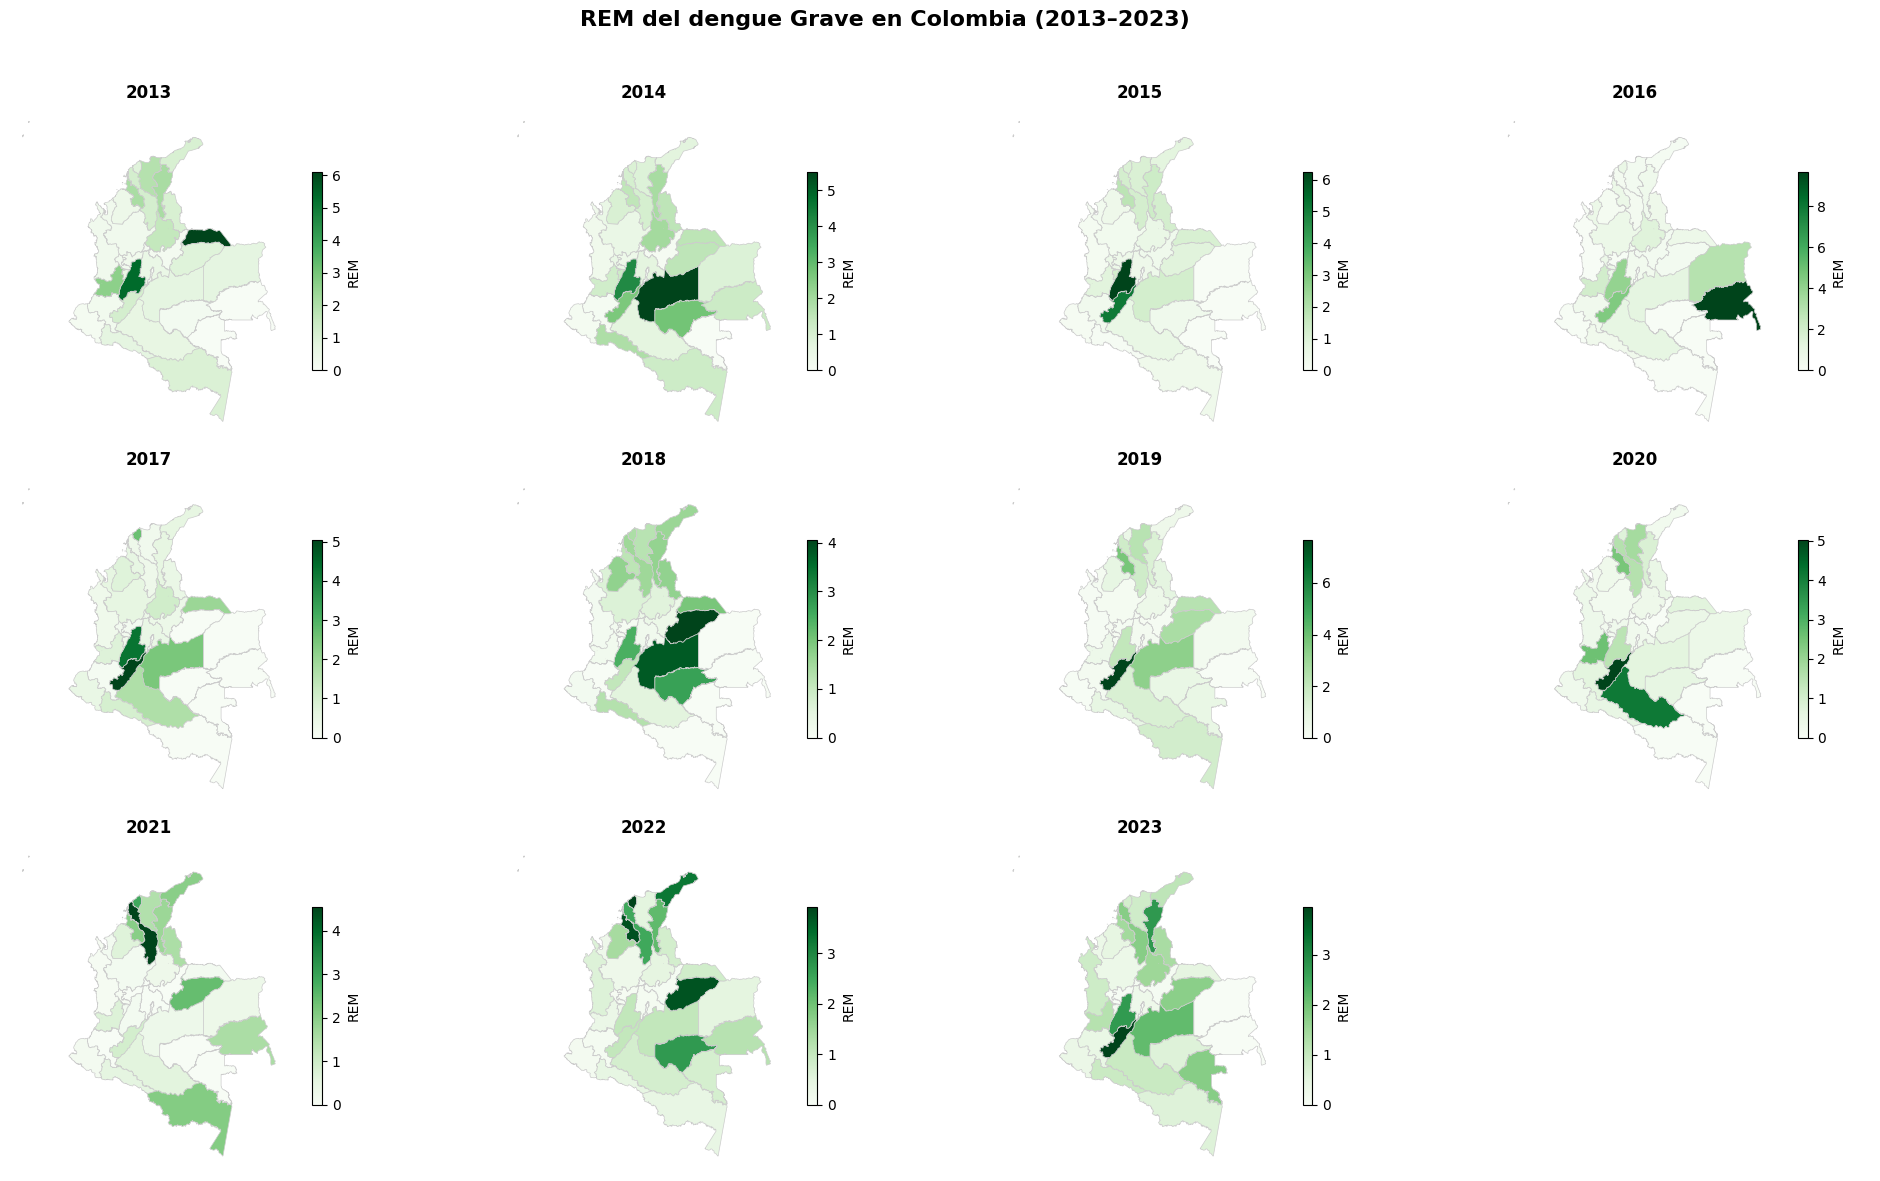

In [37]:
graficar_panel_rem(rem_grave, shp, evento="Grave")

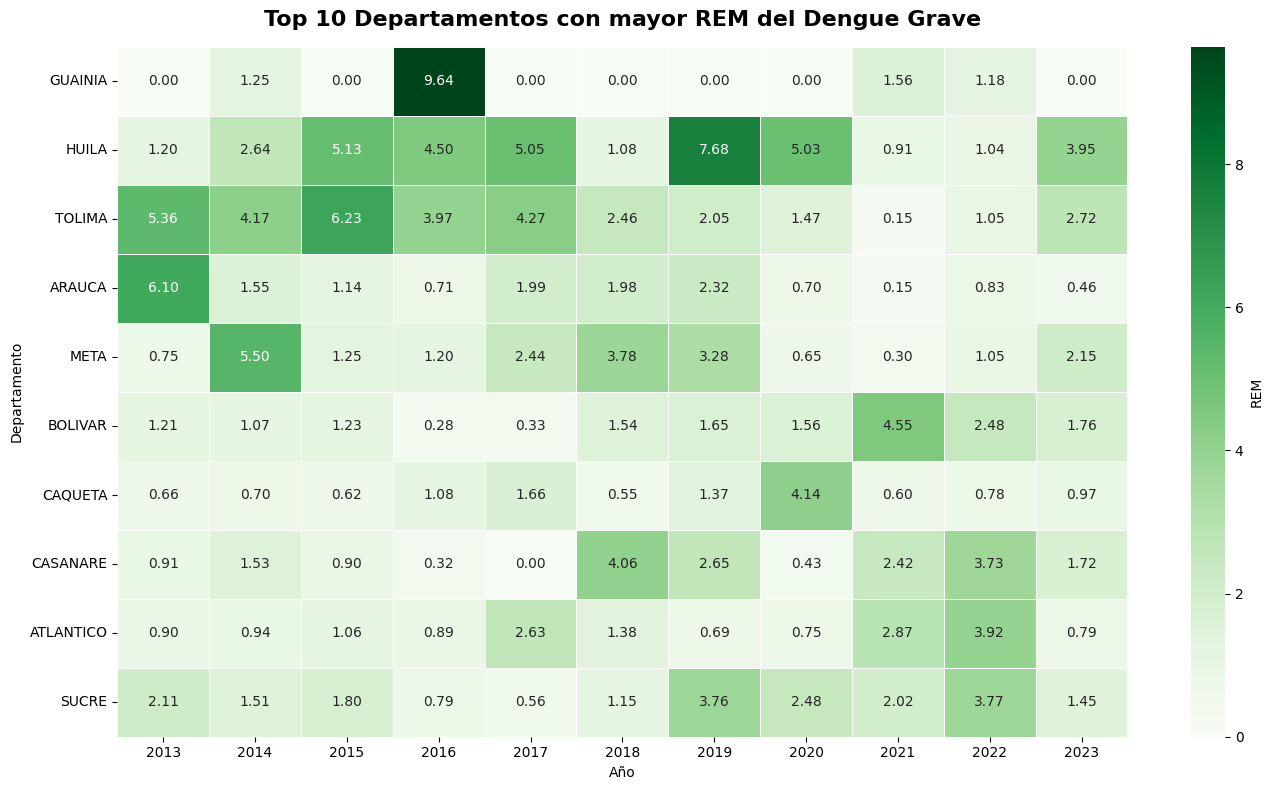

In [25]:


# === 1. Pivotear ===
tabla_grave_rem = rem_grave.pivot(
    index="departamento", 
    columns="anio", 
    values="rem"
).fillna(0)

# === 2. Seleccionar top 10 departamentos con mayores valores de REM ===
top10_departamentos = (
    tabla_grave_rem.max(axis=1)  # máximo de cada depto en todos los años
    .nlargest(10)                  # los 10 más altos
    .index                         # nombres de los deptos
)
tabla_top10 = tabla_grave_rem.loc[top10_departamentos]

# === 3. Graficar heatmap ===
plt.figure(figsize=(14, 8))
sns.heatmap(
    tabla_top10,
    cmap="Greens",
    annot=True,
    fmt=".2f",              # <-- mostrar con 2 decimales
    linewidths=0.5,
    cbar_kws={'label': 'REM'}
)

plt.title("Top 10 Departamentos con mayor REM del Dengue Grave", 
          fontsize=16, fontweight="bold", pad=15)
plt.xlabel("Año")
plt.ylabel("Departamento")
plt.tight_layout()
plt.show()


In [19]:
# === 1. Aplanar la tabla a formato largo ===
df_long = tabla_grave_rem.reset_index().melt(
    id_vars="departamento", 
    var_name="anio", 
    value_name="rem"
)

# === 2. Ordenar por rem descendente y tomar los 10 más altos ===
top10_rem = df_long.sort_values(by="rem", ascending=False).head(10)

# === 3. Mostrar resultado ===
top10_rem


departamento  anio       rem
115      GUAINIA  2016  9.640146
216        HUILA  2019  7.679201
95        TOLIMA  2015  6.231520
2         ARAUCA  2013  6.096377
54          META  2014  5.503307
29        TOLIMA  2013  5.359629
84         HUILA  2015  5.127114
150        HUILA  2017  5.052288
249        HUILA  2020  5.032080
270      BOLIVAR  2021  4.550099